In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis, normaltest, chi2_contingency

from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import joblib
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [3]:
# ============================================================================
# 1. DATA LOADING
# ============================================================================
print("="*80)
print("LOADING DATA")
print("="*80)

train = pd.read_csv("train_dataset.csv")
test = pd.read_csv("test_dataset.csv")

print(f"\nTraining data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

LOADING DATA

Training data shape: (8000, 7)
Test data shape: (2000, 5)


In [4]:
# ============================================================================
# 2. INITIAL DATA EXPLORATION
# ============================================================================
print("\n" + "="*80)
print("INITIAL DATA EXPLORATION")
print("="*80)

print("\n--- Training Data Info ---")
print(train.info())

print("\n--- Training Data First 5 Rows ---")
print(train.head())

print("\n--- Training Data Statistical Summary ---")
print(train.describe())

print("\n--- Test Data Info ---")
print(test.info())

print("\n--- Test Data First 5 Rows ---")
print(test.head())


INITIAL DATA EXPLORATION

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   q1_score     8000 non-null   float64
 1   q2_score     8000 non-null   float64
 2   q3_score     8000 non-null   float64
 3   q4_score     8000 non-null   float64
 4   q5_score     8000 non-null   float64
 5   total_score  8000 non-null   float64
 6   final_grade  8000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 437.6+ KB
None

--- Training Data First 5 Rows ---
   q1_score  q2_score  q3_score  q4_score  q5_score  total_score final_grade
0  3.374770  0.968922  9.689485  5.793474  6.242745    26.069395           C
1  7.755053  7.893796  1.951058  7.787626  4.795955    30.183488           B
2  6.238958  2.088370  9.893550  5.692865  0.241025    24.154769        Fail
3  0.355902  8.059056  1.282482  3.324825  7.037649    20.0

In [5]:
# ============================================================================
# 3. TARGET VARIABLE IDENTIFICATION
# ============================================================================
target_col = train.columns[-1]
print(f"\nTarget Column: {target_col}")

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
X_test = test.copy()

# Determine problem type
if y_train.dtype == "object" or y_train.nunique() <= 10:
    problem_type = "classification"
else:
    problem_type = "regression"

print(f"Problem Type: {problem_type.upper()}")
print(f"Target unique values: {y_train.nunique()}")


Target Column: final_grade
Problem Type: CLASSIFICATION
Target unique values: 4


In [6]:
# ============================================================================
# 4. FEATURE TYPE IDENTIFICATION
# ============================================================================
numeric_features = X_train.select_dtypes(include="number").columns.tolist()
categorical_features = X_train.select_dtypes(exclude="number").columns.tolist()

print(f"\nNumeric Features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")


Numeric Features (6): ['q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score', 'total_score']
Categorical Features (0): []



TARGET VARIABLE ANALYSIS


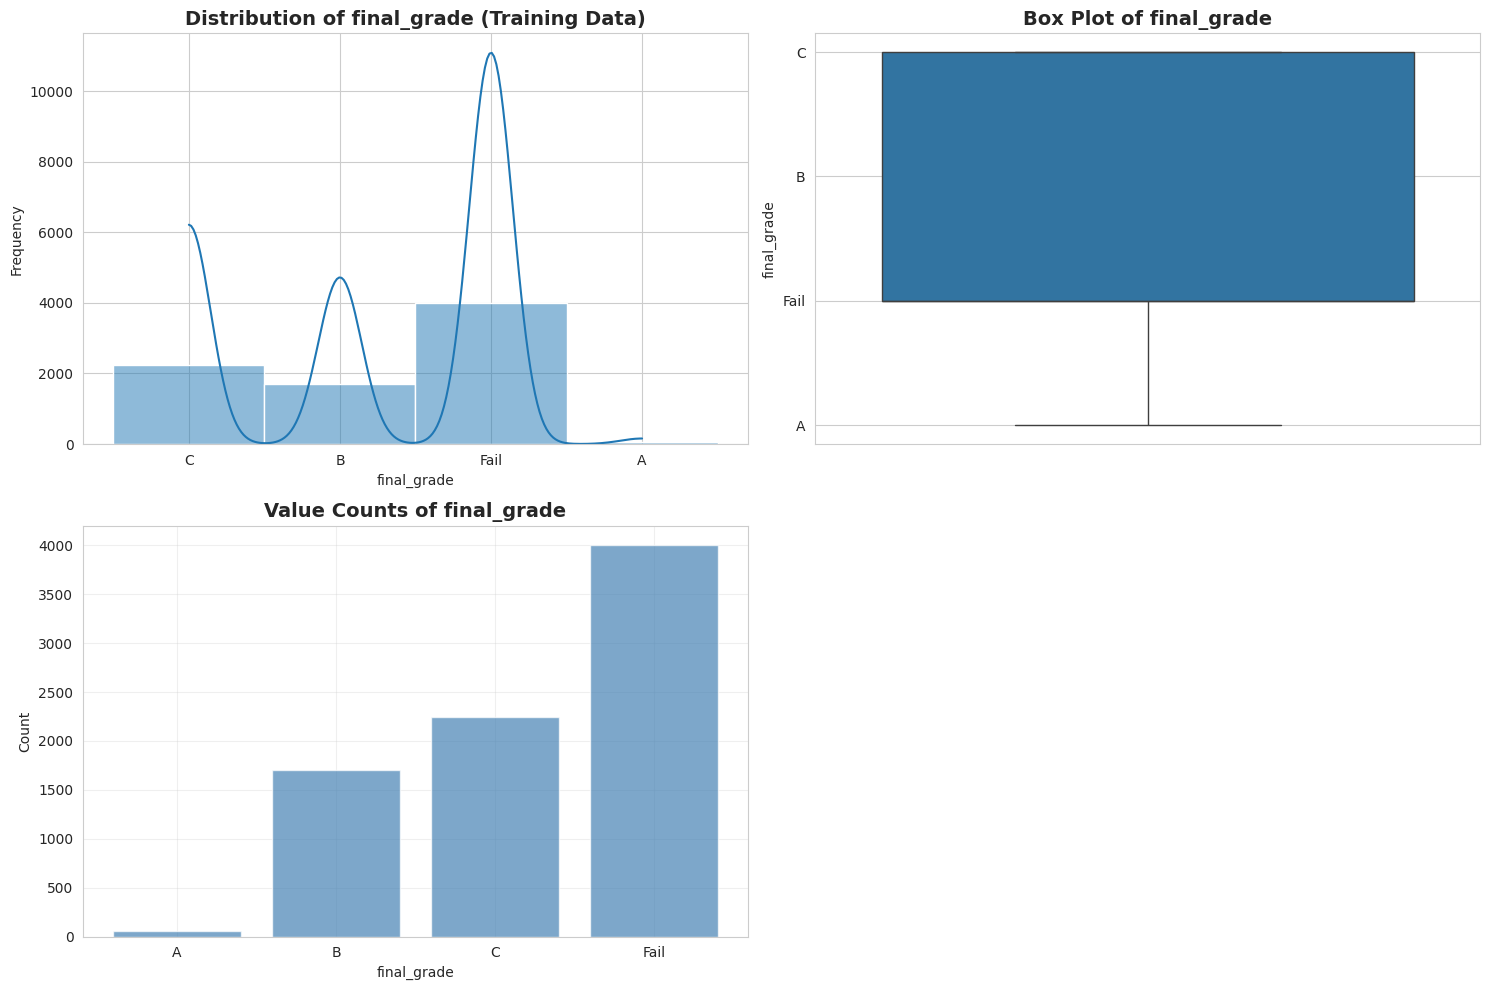


--- Statistical Measures for final_grade ---
Statistical measures like Mean, Median, Std Dev, Skewness, Kurtosis are not directly applicable to categorical variables.
Value Counts:
final_grade
Fail    3999
C       2241
B       1703
A         57
Name: count, dtype: int64


In [8]:
# ============================================================================
# 5. COMPREHENSIVE TARGET VARIABLE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution plot
sns.histplot(y_train, kde=True, ax=axes[0, 0], bins=30)
axes[0, 0].set_title(f'Distribution of {target_col} (Training Data)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(target_col)
axes[0, 0].set_ylabel('Frequency')

# Box plot
sns.boxplot(y=y_train, ax=axes[0, 1])
axes[0, 1].set_title(f'Box Plot of {target_col}', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel(target_col)

# Count plot (for discrete values)
if y_train.nunique() <= 20:
    value_counts = y_train.value_counts().sort_index()
    axes[1, 0].bar(value_counts.index, value_counts.values, color='steelblue', alpha=0.7)
    axes[1, 0].set_title(f'Value Counts of {target_col}', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel(target_col)
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(True, alpha=0.3)
else:
    sns.kdeplot(y_train, ax=axes[1, 0], fill=True)
    axes[1, 0].set_title(f'Density Plot of {target_col}', fontsize=14, fontweight='bold')

# QQ plot for normality check - Not applicable for categorical target variable
axes[1, 1].set_visible(False) # Hide this subplot as it's not applicable
axes[1, 1].set_title(f'Q-Q Plot of {target_col} (Not Applicable)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('target_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical measures - Not applicable for categorical target variable
print(f"\n--- Statistical Measures for {target_col} ---")
print("Statistical measures like Mean, Median, Std Dev, Skewness, Kurtosis are not directly applicable to categorical variables.")
print(f"Value Counts:\n{y_train.value_counts()}")


MISSING VALUES ANALYSIS

--- Training Data Missing Values ---
Series([], dtype: int64)

--- Test Data Missing Values ---
Series([], dtype: int64)


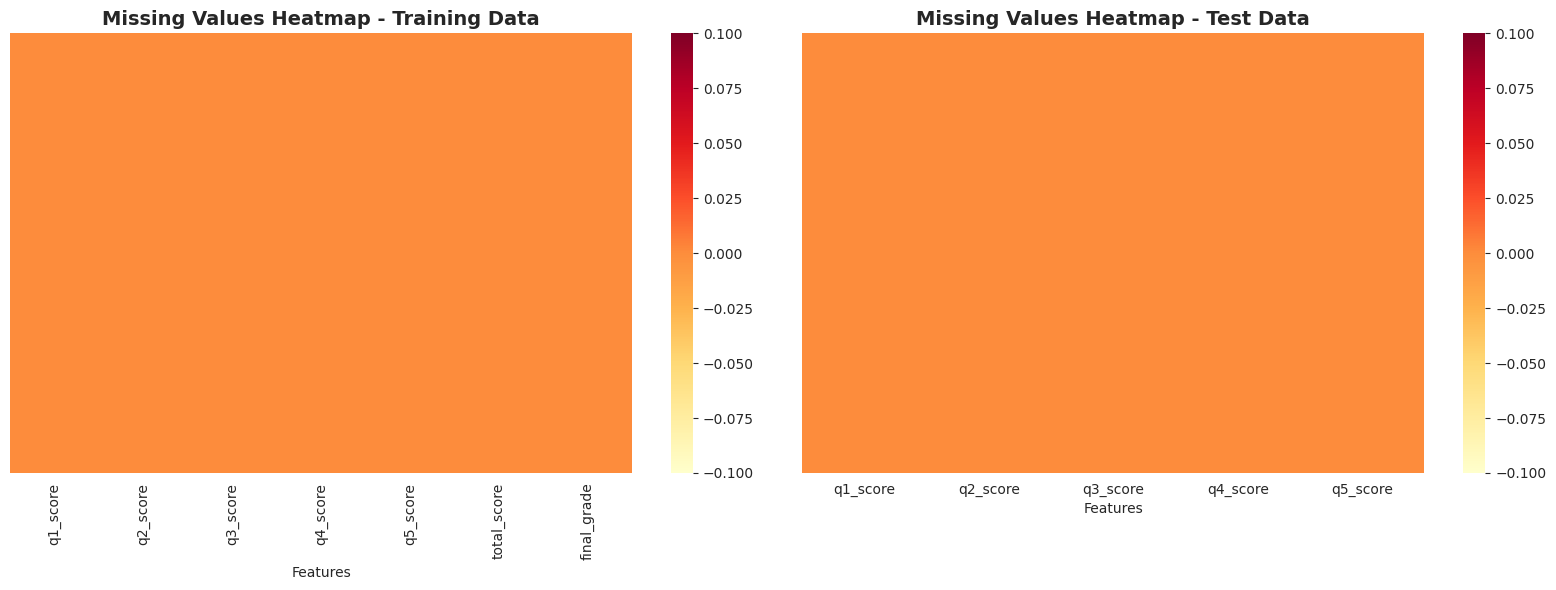

In [9]:
# ============================================================================
# 6. MISSING VALUES ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

# Calculate missing values
train_missing = train.isnull().sum()
test_missing = test.isnull().sum()

print("\n--- Training Data Missing Values ---")
print(train_missing[train_missing > 0])

print("\n--- Test Data Missing Values ---")
print(test_missing[test_missing > 0])

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training data
sns.heatmap(train.isnull(), cbar=True, cmap='YlOrRd', ax=axes[0], yticklabels=False)
axes[0].set_title('Missing Values Heatmap - Training Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Features')

# Test data
sns.heatmap(test.isnull(), cbar=True, cmap='YlOrRd', ax=axes[1], yticklabels=False)
axes[1].set_title('Missing Values Heatmap - Test Data', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Features')

plt.tight_layout()
plt.savefig('missing_values.png', dpi=300, bbox_inches='tight')
plt.show()

# Missing values percentage
if train_missing.sum() > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    missing_pct = (train_missing / len(train) * 100).sort_values(ascending=False)
    missing_pct = missing_pct[missing_pct > 0]

    if len(missing_pct) > 0:
        missing_pct.plot(kind='barh', ax=ax, color='coral')
        ax.set_title('Percentage of Missing Values by Feature (Training)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Percentage Missing (%)')
        ax.set_ylabel('Features')
        plt.tight_layout()
        plt.savefig('missing_percentage.png', dpi=300, bbox_inches='tight')
        plt.show()


NUMERIC FEATURES ANALYSIS

--- Statistical Summary of Numeric Features ---
          q1_score     q2_score     q3_score     q4_score     q5_score  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean      4.943580     5.062148     4.992995     4.982647     4.977448   
std       2.868347     2.897328     2.873422     2.880014     2.902864   
min       0.000116     0.001577     0.000481     0.000976     0.000167   
25%       2.483541     2.542456     2.520587     2.468572     2.456092   
50%       4.920590     5.106285     5.007983     4.988625     4.951150   
75%       7.403538     7.570337     7.452189     7.460723     7.535297   
max       9.997177     9.998714     9.999010     9.996972     9.999570   

       total_score  
count  8000.000000  
mean     24.958818  
std       6.367436  
min       3.433132  
25%      20.536385  
50%      25.008425  
75%      29.344652  
max      44.216352  

q1_score:
  Mean: 4.9436
  Median: 4.9206
  Std: 2.8683
  Skewness:

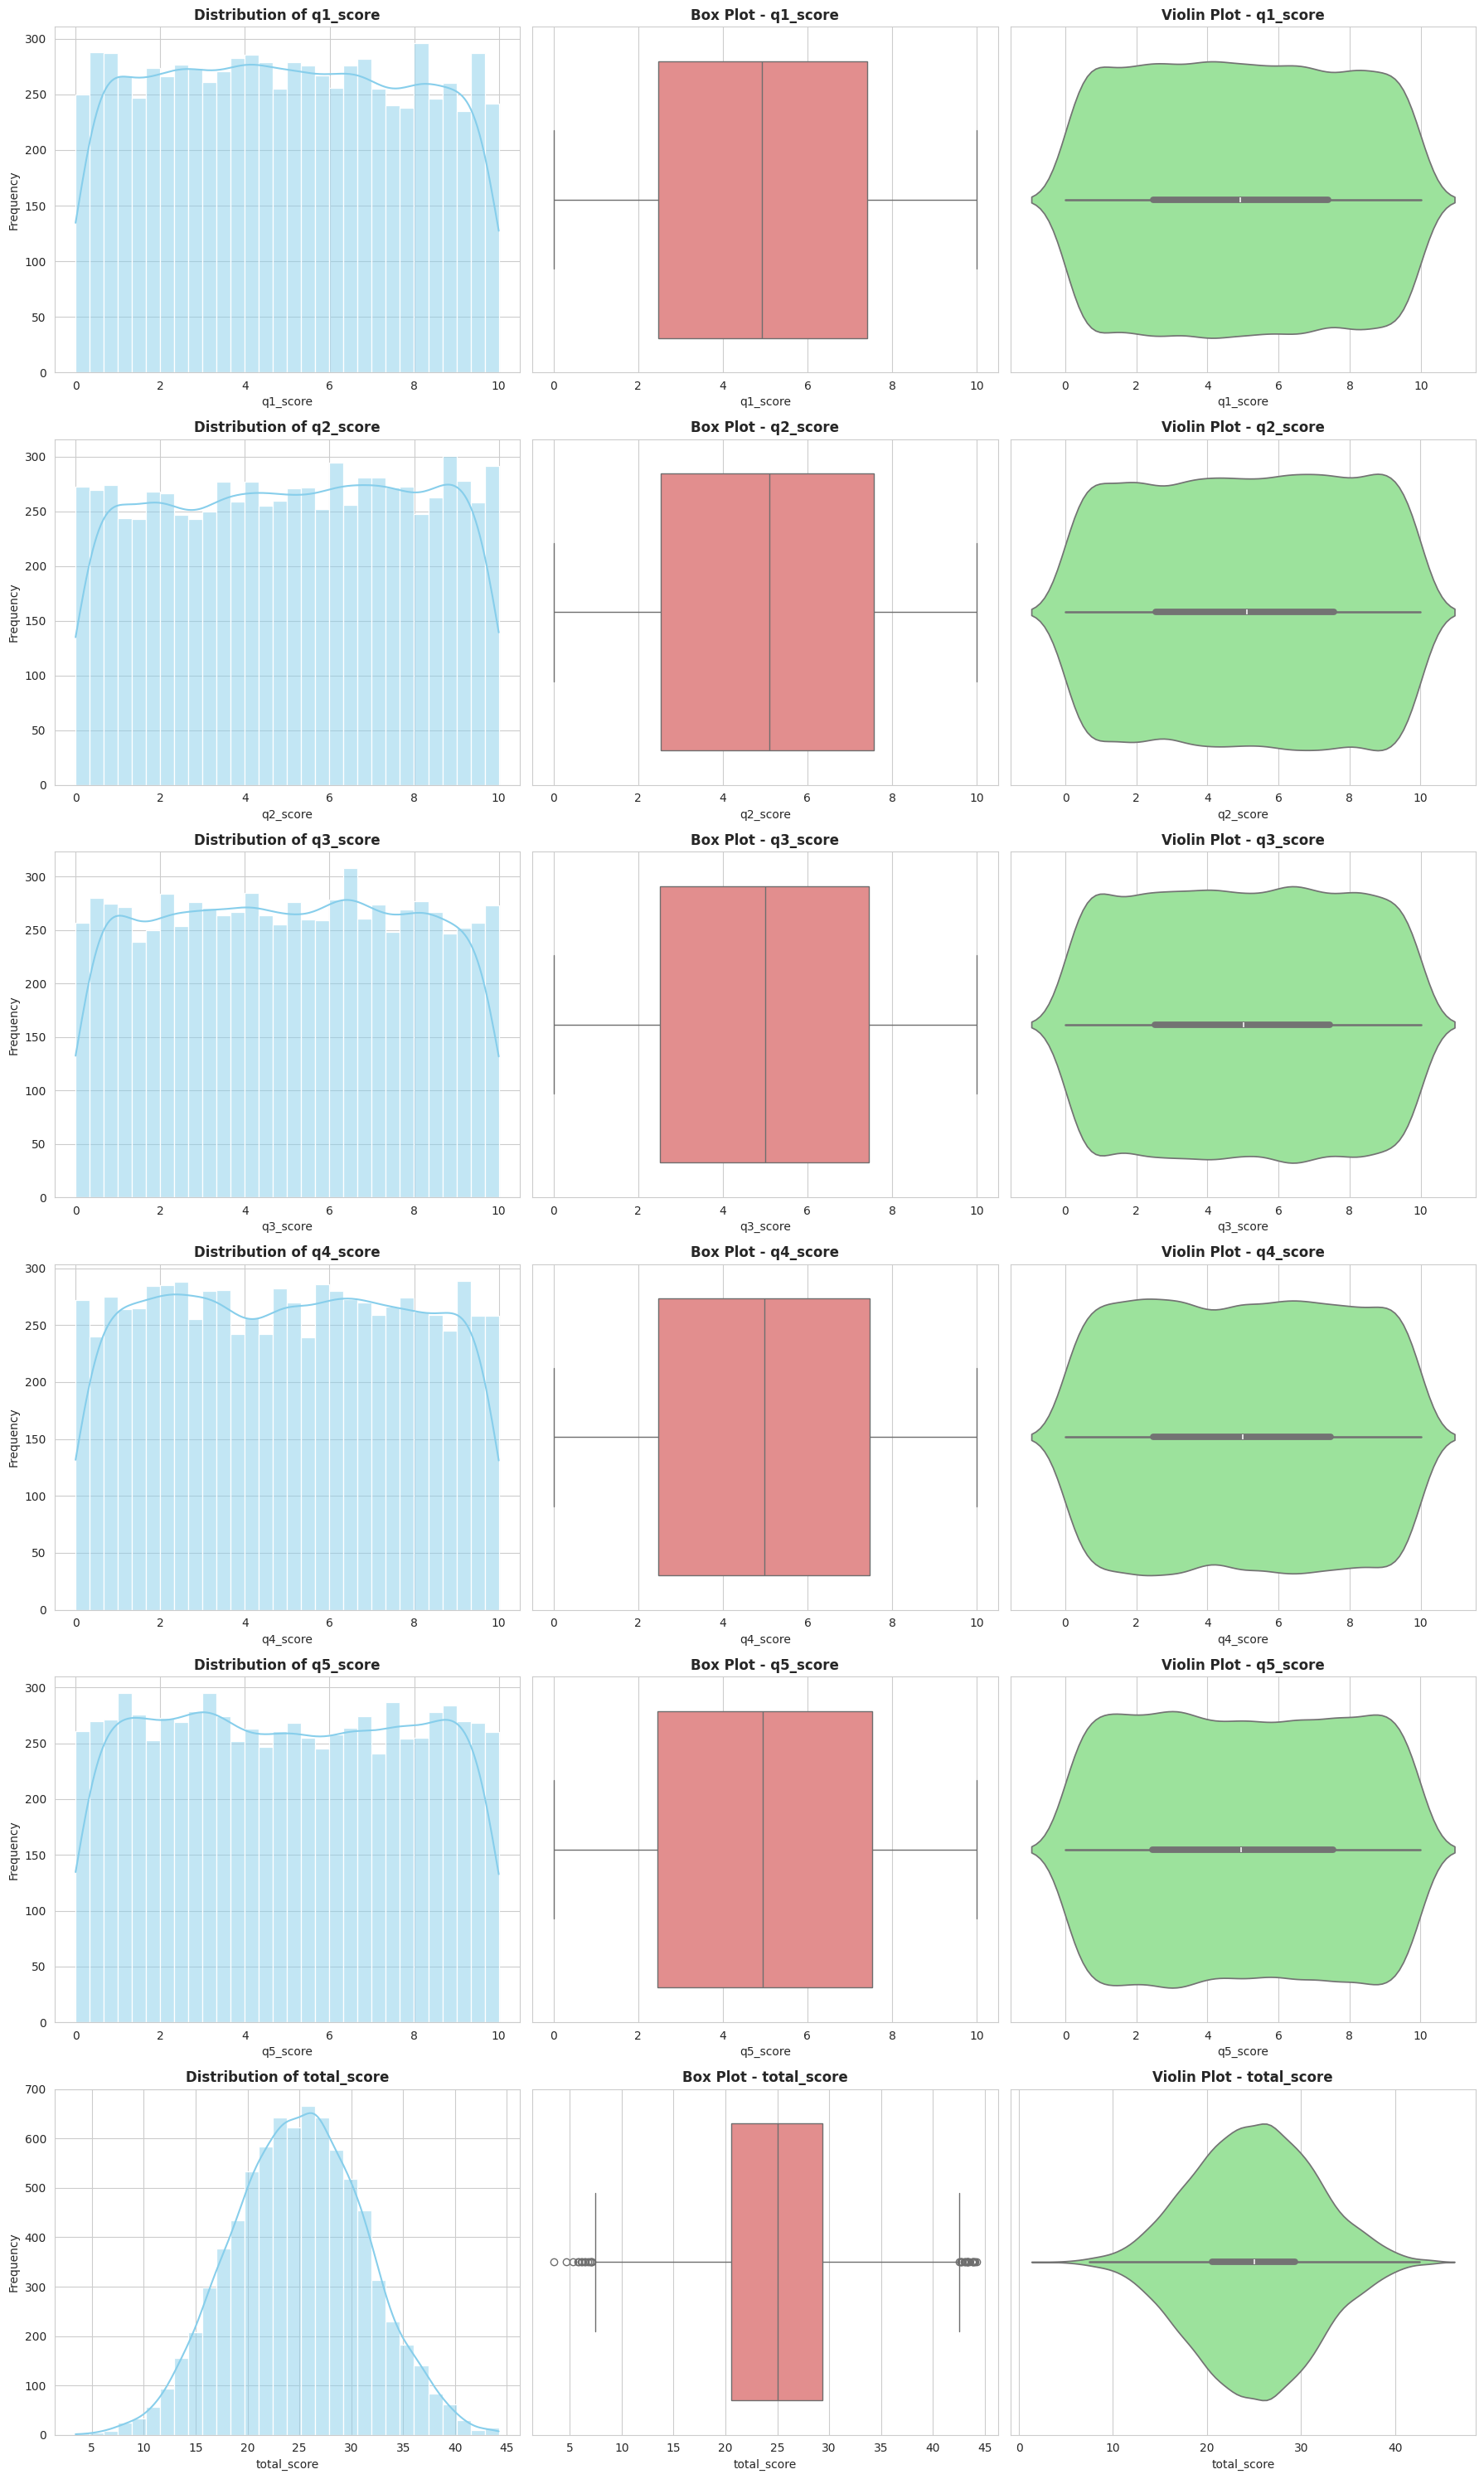


--- Pairwise Relationships ---


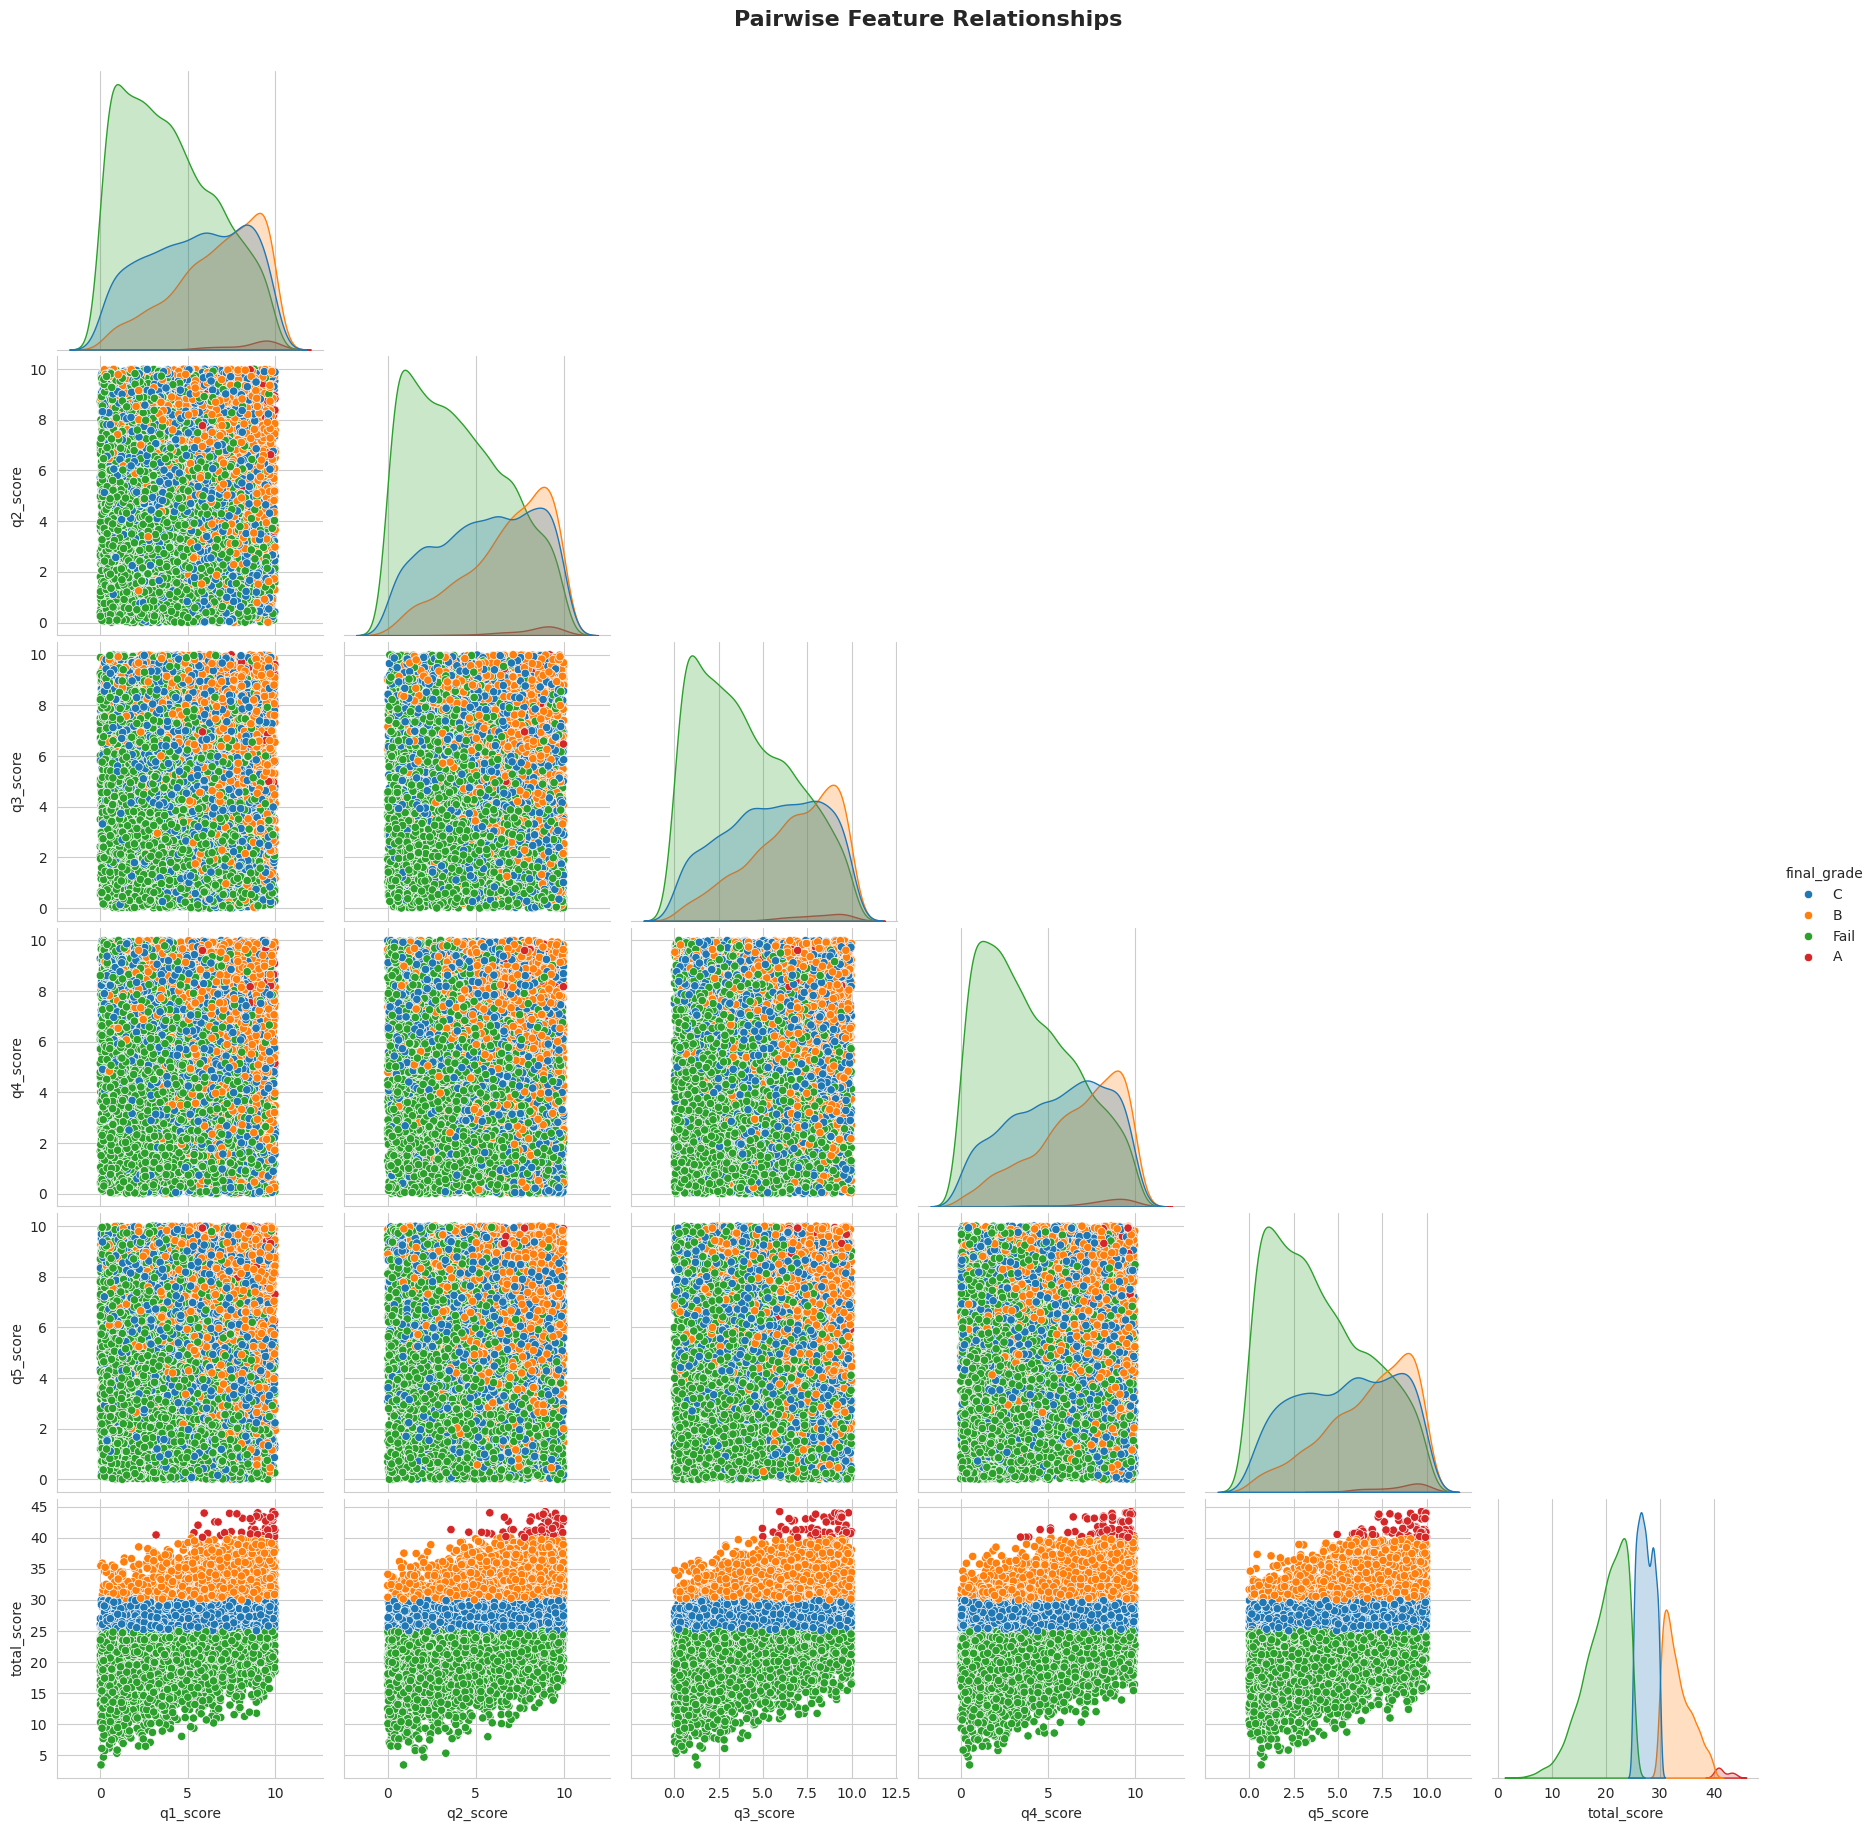

In [10]:
# ============================================================================
# 7. NUMERIC FEATURES ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("NUMERIC FEATURES ANALYSIS")
print("="*80)

if len(numeric_features) > 0:
    print("\n--- Statistical Summary of Numeric Features ---")
    print(X_train[numeric_features].describe())

    # Distribution and outlier analysis
    num_features_len = len(numeric_features)
    fig, axes = plt.subplots(num_features_len, 3, figsize=(18, 5 * num_features_len))

    if num_features_len == 1:
        axes = axes.reshape(1, -1)

    for i, col in enumerate(numeric_features):
        # Histogram with KDE
        sns.histplot(X_train[col], kde=True, ax=axes[i, 0], bins=30, color='skyblue')
        axes[i, 0].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Box plot for outliers
        sns.boxplot(x=X_train[col], ax=axes[i, 1], color='lightcoral')
        axes[i, 1].set_title(f'Box Plot - {col}', fontsize=12, fontweight='bold')
        axes[i, 1].set_xlabel(col)

        # Violin plot
        sns.violinplot(x=X_train[col], ax=axes[i, 2], color='lightgreen')
        axes[i, 2].set_title(f'Violin Plot - {col}', fontsize=12, fontweight='bold')
        axes[i, 2].set_xlabel(col)

        # Print statistics for each feature
        print(f"\n{col}:")
        print(f"  Mean: {X_train[col].mean():.4f}")
        print(f"  Median: {X_train[col].median():.4f}")
        print(f"  Std: {X_train[col].std():.4f}")
        print(f"  Skewness: {skew(X_train[col].dropna()):.4f}")
        print(f"  Kurtosis: {kurtosis(X_train[col].dropna()):.4f}")

        # Detect outliers using IQR method
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = X_train[(X_train[col] < Q1 - 1.5*IQR) | (X_train[col] > Q3 + 1.5*IQR)][col]
        print(f"  Outliers: {len(outliers)} ({len(outliers)/len(X_train)*100:.2f}%)")

    plt.tight_layout()
    plt.savefig('numeric_features_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Pairwise scatter plots for numeric features
    if len(numeric_features) > 1 and len(numeric_features) <= 6:
        print("\n--- Pairwise Relationships ---")
        pairplot_df = X_train[numeric_features].copy()
        pairplot_df[target_col] = y_train

        g = sns.pairplot(pairplot_df, hue=target_col if y_train.nunique() <= 10 else None,
                        diag_kind='kde', corner=True, height=3)
        g.fig.suptitle('Pairwise Feature Relationships', y=1.02, fontsize=16, fontweight='bold')
        plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
        plt.show()


In [11]:
# ============================================================================
# 8. CATEGORICAL FEATURES ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*80)

if len(categorical_features) > 0:
    for col in categorical_features:
        print(f"\n--- {col} ---")
        print(f"Unique values: {X_train[col].nunique()}")
        print(f"Value counts:\n{X_train[col].value_counts()}")

        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Bar plot
        value_counts = X_train[col].value_counts()
        axes[0].bar(range(len(value_counts)), value_counts.values, color='steelblue', alpha=0.7)
        axes[0].set_xticks(range(len(value_counts)))
        axes[0].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[0].set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')
        axes[0].grid(True, alpha=0.3)

        # Pie chart
        axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
        axes[1].set_title(f'Proportion of {col}', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'categorical_{col}.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No categorical features found.")


CATEGORICAL FEATURES ANALYSIS
No categorical features found.



CORRELATION ANALYSIS

ENCODING TARGET VARIABLE FOR CORRELATION ANALYSIS
Grade mapping created: {'Fail': 0, 'C': 1, 'B': 2, 'A': 3}

Original y_train head:
0       C
1       B
2    Fail
3    Fail
4       B
Name: final_grade, dtype: object

Encoded y_train_encoded head:
0    1
1    2
2    0
3    0
4    2
Name: final_grade, dtype: int64

Updated correlation_data head with encoded target:
   q1_score  q2_score  q3_score  q4_score  q5_score  total_score  final_grade
0  3.374770  0.968922  9.689485  5.793474  6.242745    26.069395            1
1  7.755053  7.893796  1.951058  7.787626  4.795955    30.183488            2
2  6.238958  2.088370  9.893550  5.692865  0.241025    24.154769            0
3  0.355902  8.059056  1.282482  3.324825  7.037649    20.059915            0
4  5.771171  9.419105  3.547509  8.456577  6.069714    33.264077            2


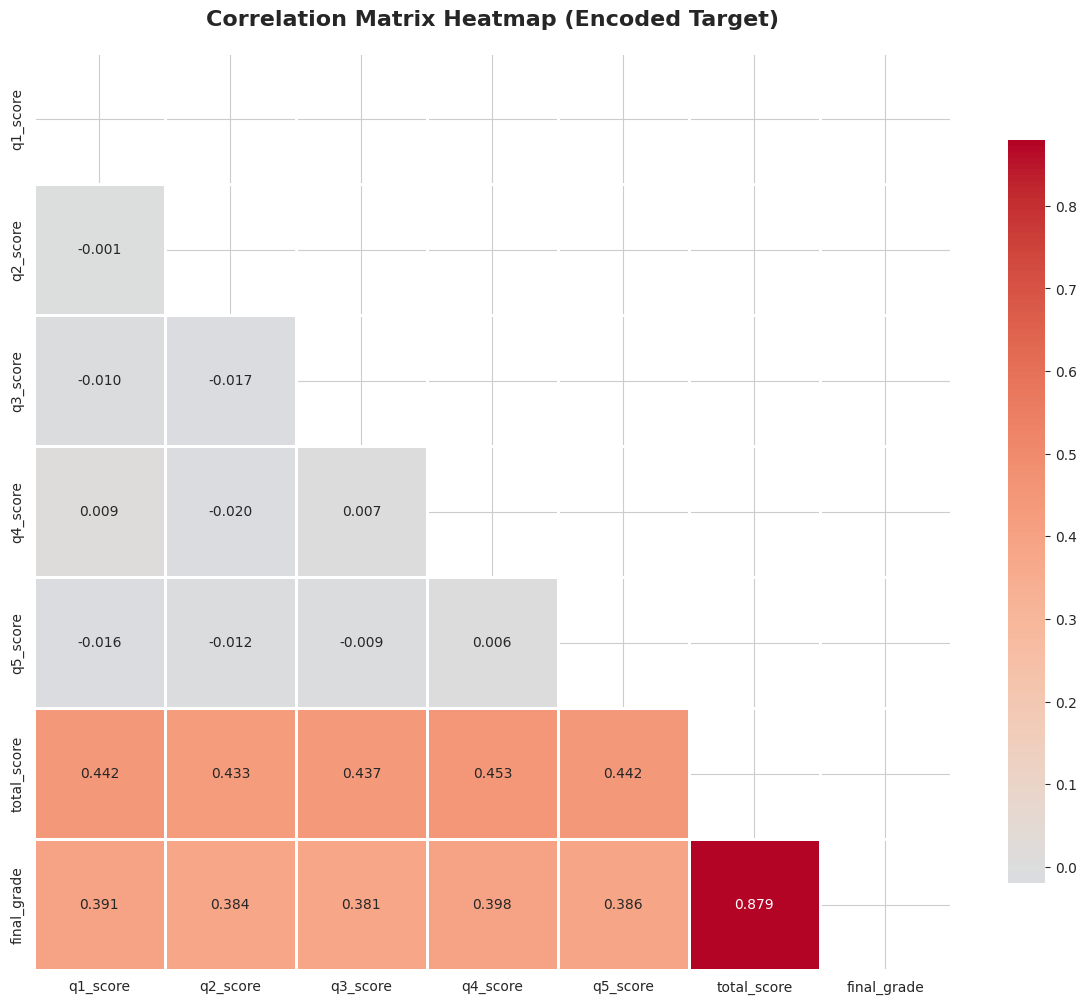


--- Correlation with final_grade (Encoded) ---
total_score    0.879302
q4_score       0.397939
q1_score       0.391334
q5_score       0.386303
q2_score       0.384138
q3_score       0.381422
Name: final_grade, dtype: float64


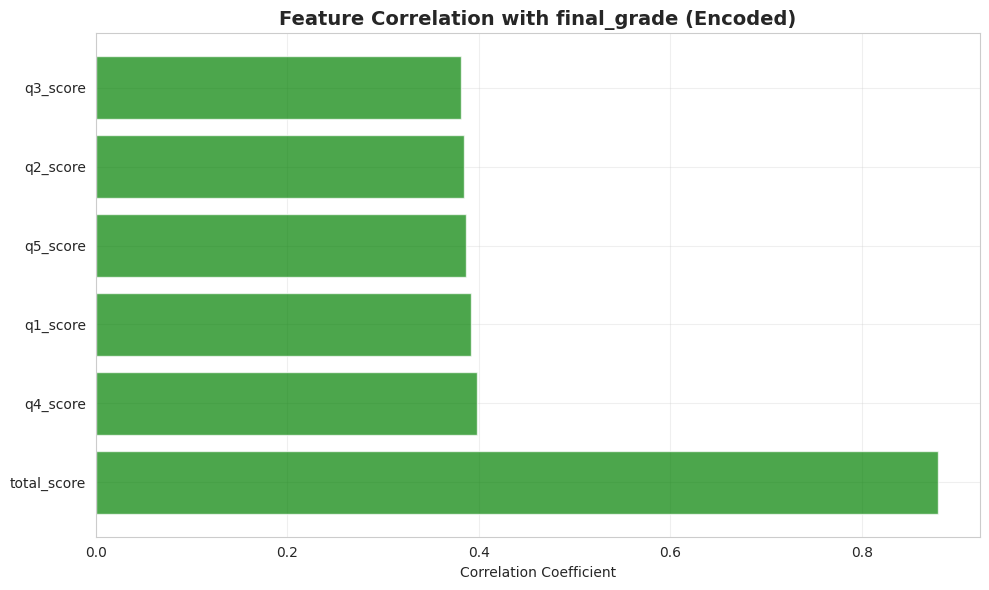


--- Highly Correlated Feature Pairs (|r| > 0.7) ---
No highly correlated feature pairs found (excluding target). For all pairs, refer to the heatmap.


In [15]:
# ============================================================================
# 9. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

if len(numeric_features) > 1:
    # Encode target variable for correlation analysis
    print("\n" + "="*80)
    print("ENCODING TARGET VARIABLE FOR CORRELATION ANALYSIS")
    print("="*80)

    grade_mapping = {'Fail': 0, 'C': 1, 'B': 2, 'A': 3}
    print(f"Grade mapping created: {grade_mapping}")

    # Apply this mapping to y_train to create y_train_encoded
    y_train_encoded = y_train.map(grade_mapping)
    print(f"\nOriginal y_train head:\n{y_train.head()}")
    print(f"\nEncoded y_train_encoded head:\n{y_train_encoded.head()}")

    # Correlation with target
    correlation_data = X_train[numeric_features].copy()
    correlation_data[target_col] = y_train_encoded
    print(f"\nUpdated correlation_data head with encoded target:\n{correlation_data.head()}")

    correlation_matrix = correlation_data.corr()

    # Full correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f',
                cmap='coolwarm', center=0, square=True, linewidths=1,
                cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix Heatmap (Encoded Target)', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('correlation_heatmap_encoded.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Correlation with target variable
    target_corr = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)

    print(f"\n--- Correlation with {target_col} (Encoded) ---")
    print(target_corr)

    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in target_corr.values]
    plt.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
    plt.yticks(range(len(target_corr)), target_corr.index)
    plt.xlabel('Correlation Coefficient')
    plt.title(f'Feature Correlation with {target_col} (Encoded)', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('target_correlation_encoded.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Highly correlated feature pairs
    print("\n--- Highly Correlated Feature Pairs (|r| > 0.7) ---")
    high_corr_pairs = []
    # Iterate only through the upper triangle to avoid duplicates and self-correlation
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            # Ensure neither feature is the target variable itself for general feature-to-feature correlation
            if correlation_matrix.columns[i] != target_col and correlation_matrix.columns[j] != target_col:
                if abs(correlation_matrix.iloc[i, j]) > 0.7:
                    high_corr_pairs.append({
                        'Feature 1': correlation_matrix.columns[i],
                        'Feature 2': correlation_matrix.columns[j],
                        'Correlation': correlation_matrix.iloc[i, j]
                    })

    if high_corr_pairs:
        print(pd.DataFrame(high_corr_pairs))
    else:
        print("No highly correlated feature pairs found (excluding target). For all pairs, refer to the heatmap.")
else:
    print("Not enough numeric features for correlation analysis.")


FEATURE vs TARGET RELATIONSHIP ANALYSIS


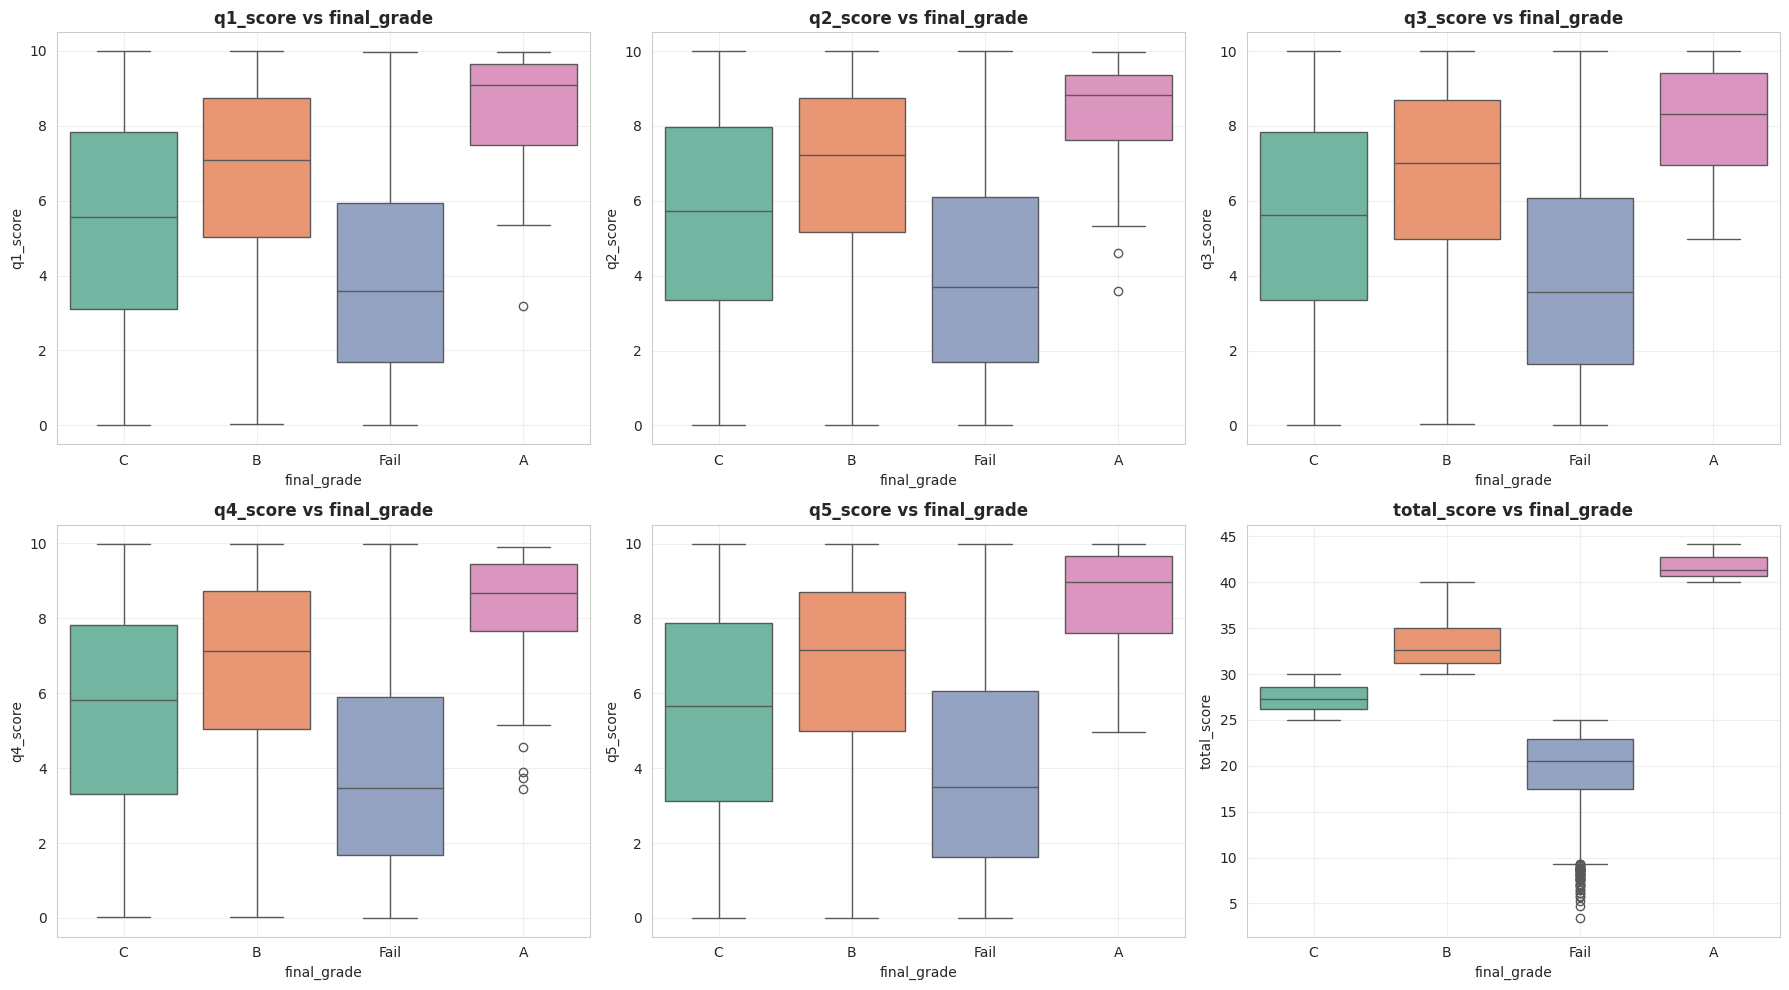

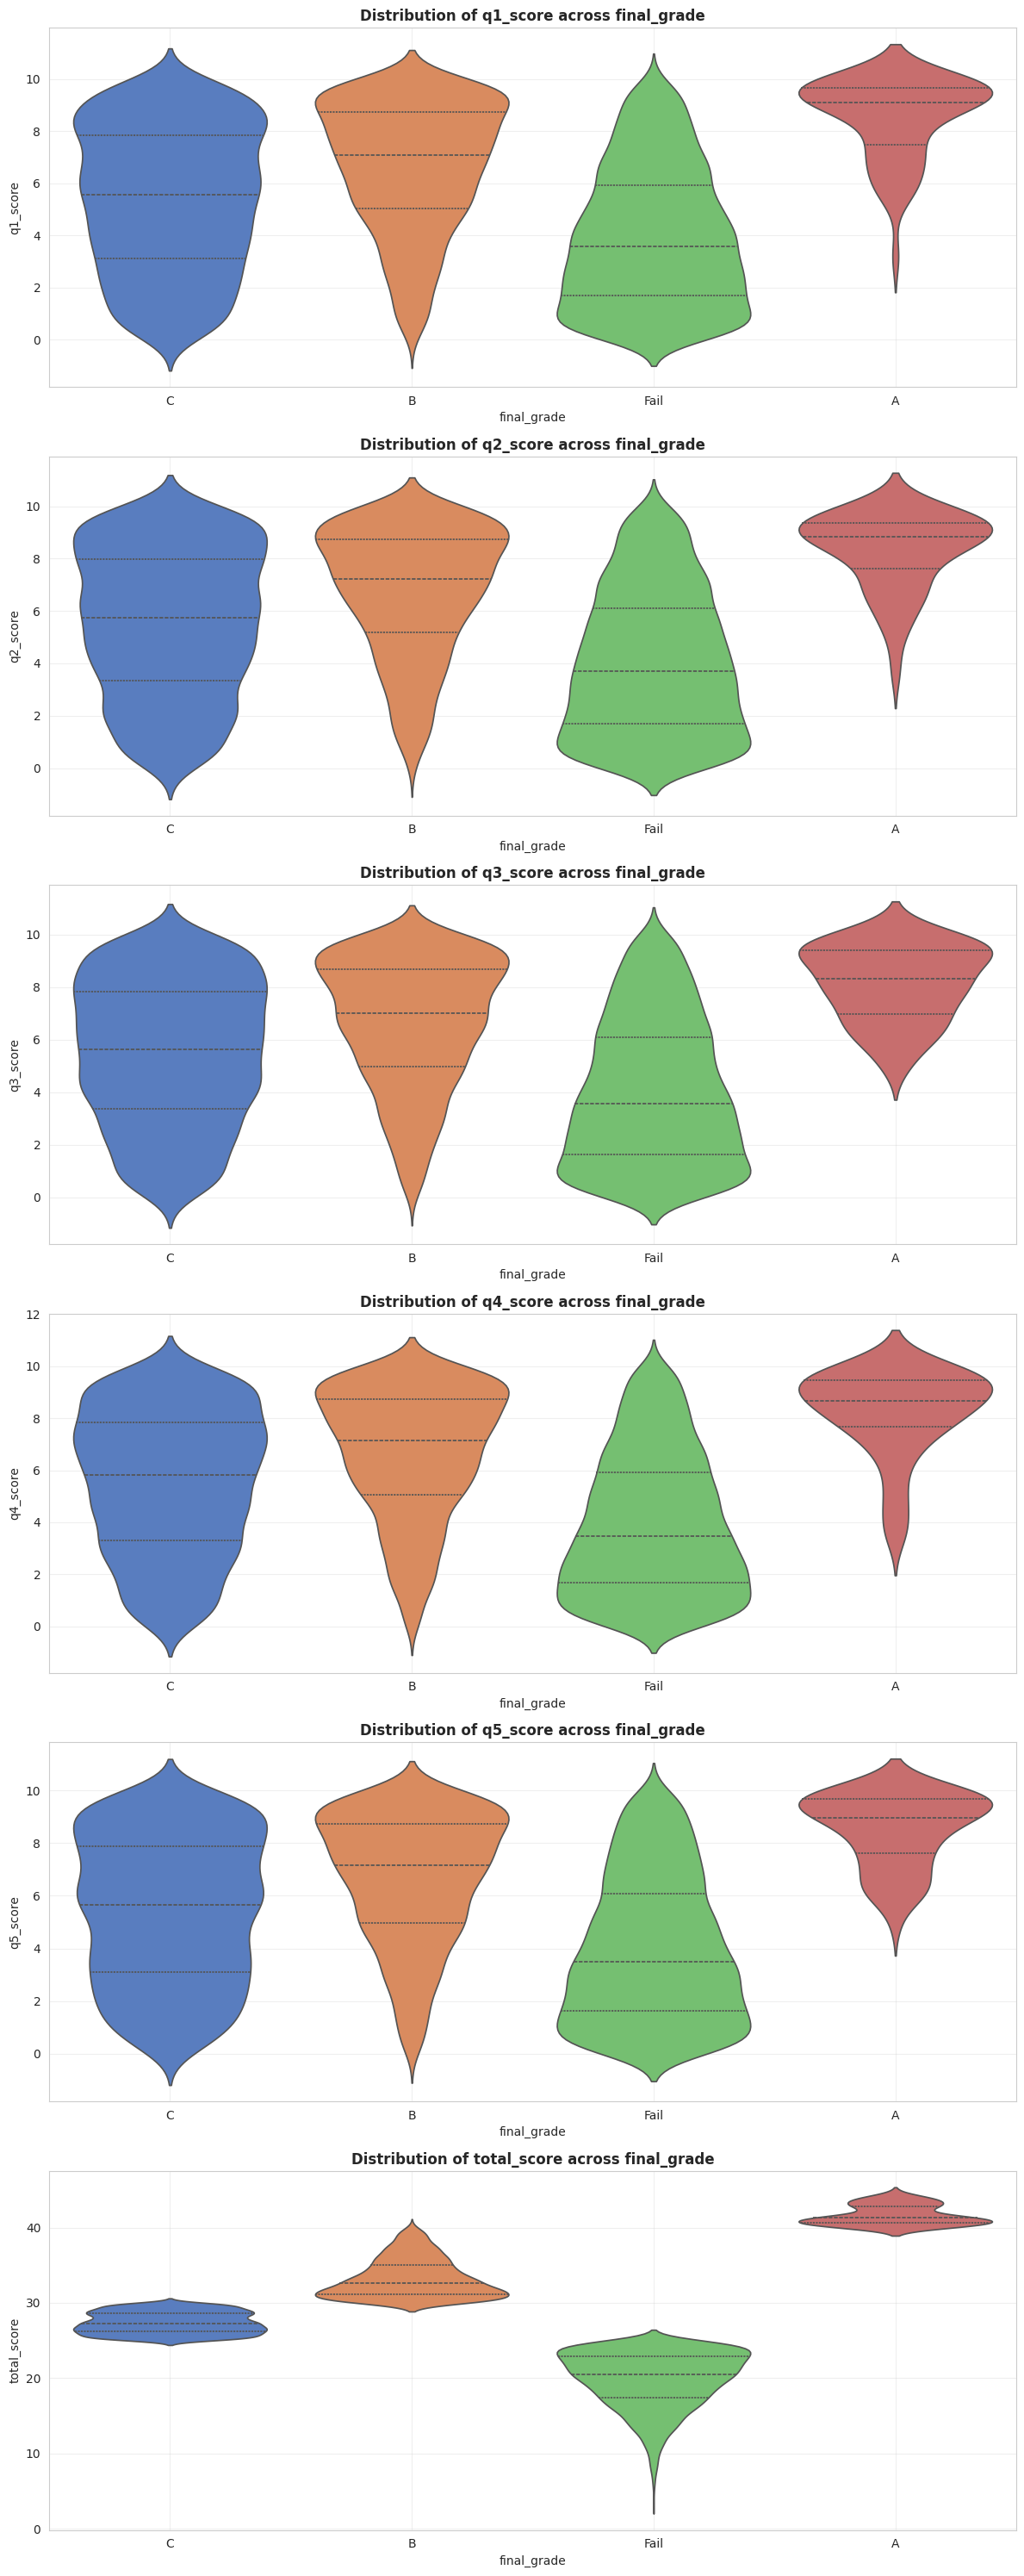

In [16]:
# ============================================================================
# 10. FEATURE vs TARGET RELATIONSHIP ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("FEATURE vs TARGET RELATIONSHIP ANALYSIS")
print("="*80)

if len(numeric_features) > 0:
    # Scatter plots
    num_cols = min(3, len(numeric_features))
    num_rows = (len(numeric_features) + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows))
    axes = axes.flatten() if len(numeric_features) > 1 else [axes]

    for i, col in enumerate(numeric_features):
        ax = axes[i]

        if problem_type == "classification" and y_train.nunique() <= 10:
            # Box plot for classification
            sns.boxplot(x=y_train, y=X_train[col], ax=ax, palette='Set2')
            ax.set_title(f'{col} vs {target_col}', fontsize=12, fontweight='bold')
            ax.set_xlabel(target_col)
            ax.set_ylabel(col)
        else:
            # Scatter plot for regression
            ax.scatter(X_train[col], y_train, alpha=0.5, s=20)
            ax.set_title(f'{col} vs {target_col}', fontsize=12, fontweight='bold')
            ax.set_xlabel(col)
            ax.set_ylabel(target_col)

            # Add trend line
            z = np.polyfit(X_train[col].dropna(), y_train[X_train[col].notna()], 1)
            p = np.poly1d(z)
            ax.plot(X_train[col].sort_values(), p(X_train[col].sort_values()),
                   "r--", alpha=0.8, linewidth=2, label='Trend')
            ax.legend()

        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(numeric_features), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig('feature_vs_target.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Violin plots for better distribution view
    if problem_type == "classification" and y_train.nunique() <= 10:
        fig, axes = plt.subplots(len(numeric_features), 1,
                                figsize=(12, 5 * len(numeric_features)))
        if len(numeric_features) == 1:
            axes = [axes]

        for i, col in enumerate(numeric_features):
            sns.violinplot(x=y_train, y=X_train[col], ax=axes[i],
                          palette='muted', inner='quartile')
            axes[i].set_title(f'Distribution of {col} across {target_col}',
                            fontsize=12, fontweight='bold')
            axes[i].set_xlabel(target_col)
            axes[i].set_ylabel(col)
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('violin_plots.png', dpi=300, bbox_inches='tight')
        plt.show()

In [17]:
# ============================================================================
# 11. DATA QUALITY CHECKS
# ============================================================================
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

# Check for duplicates
train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"\nDuplicate rows in training data: {train_duplicates}")
print(f"Duplicate rows in test data: {test_duplicates}")

# Check for constant features
constant_features = []
for col in X_train.columns:
    if X_train[col].nunique() == 1:
        constant_features.append(col)

if constant_features:
    print(f"\nConstant features (should be removed): {constant_features}")
else:
    print("\nNo constant features found.")

# Check data types consistency
print("\n--- Data Type Consistency Check ---")
print("Training data types:")
print(X_train.dtypes)
print("\nTest data types:")
print(X_test.dtypes)


DATA QUALITY CHECKS

Duplicate rows in training data: 0
Duplicate rows in test data: 0

No constant features found.

--- Data Type Consistency Check ---
Training data types:
q1_score       float64
q2_score       float64
q3_score       float64
q4_score       float64
q5_score       float64
total_score    float64
dtype: object

Test data types:
q1_score    float64
q2_score    float64
q3_score    float64
q4_score    float64
q5_score    float64
dtype: object


In [18]:
# ============================================================================
# 12. ADVANCED STATISTICAL ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("ADVANCED STATISTICAL ANALYSIS")
print("="*80)

if len(numeric_features) > 0:
    print("\n--- Normality Tests (Shapiro-Wilk) ---")
    for col in numeric_features:
        # Use a sample if data is too large
        sample_data = X_train[col].dropna().sample(min(5000, len(X_train[col].dropna())),
                                                    random_state=42)
        stat, p_value = stats.shapiro(sample_data)
        print(f"{col}: statistic={stat:.4f}, p-value={p_value:.4f} "
              f"({'Normal' if p_value > 0.05 else 'Not Normal'})")

# Chi-square test for categorical features vs target
if len(categorical_features) > 0 and problem_type == "classification":
    print("\n--- Chi-Square Tests (Categorical Features vs Target) ---")
    for col in categorical_features:
        contingency_table = pd.crosstab(X_train[col], y_train)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        print(f"{col}: chi2={chi2:.4f}, p-value={p_value:.4f}, "
              f"dof={dof} ({'Significant' if p_value < 0.05 else 'Not Significant'})")


ADVANCED STATISTICAL ANALYSIS

--- Normality Tests (Shapiro-Wilk) ---
q1_score: statistic=0.9561, p-value=0.0000 (Not Normal)
q2_score: statistic=0.9557, p-value=0.0000 (Not Normal)
q3_score: statistic=0.9578, p-value=0.0000 (Not Normal)
q4_score: statistic=0.9539, p-value=0.0000 (Not Normal)
q5_score: statistic=0.9535, p-value=0.0000 (Not Normal)
total_score: statistic=0.9987, p-value=0.0007 (Not Normal)


In [19]:
# ============================================================================
# 13. PREPROCESSING PIPELINE
# ============================================================================
print("\n" + "="*80)
print("BUILDING PREPROCESSING PIPELINE")
print("="*80)

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

print("Preprocessing pipeline created successfully.")


BUILDING PREPROCESSING PIPELINE
Preprocessing pipeline created successfully.


In [20]:
# ============================================================================
# 14. MODEL SELECTION AND TRAINING
# ============================================================================
print("\n" + "="*80)
print("MODEL SELECTION AND TRAINING")
print("="*80)

if problem_type == "regression":
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=1.0),
        "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=10),
        "RandomForest": RandomForestRegressor(random_state=42, n_estimators=100),
        "GradientBoosting": GradientBoostingRegressor(random_state=42, n_estimators=100)
    }
    scoring_metric = "neg_root_mean_squared_error"

else:
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42, max_depth=10),
        "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, n_estimators=100)
    }
    scoring_metric = "f1_weighted"

print(f"\nModels to evaluate: {list(models.keys())}")
print(f"Scoring metric: {scoring_metric}")


MODEL SELECTION AND TRAINING

Models to evaluate: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']
Scoring metric: f1_weighted



CROSS-VALIDATION RESULTS

Training LogisticRegression...
LogisticRegression: Mean = 0.9923, Std = 0.0013
  Scores: [0.99275056 0.99047139 0.99410263 0.99128201 0.99273372]

Training DecisionTree...
DecisionTree: Mean = 0.9999, Std = 0.0002
  Scores: [1.         1.         1.         0.99937511 1.        ]

Training RandomForest...
RandomForest: Mean = 0.9996, Std = 0.0003
  Scores: [0.99936058 1.         1.         0.99937511 0.99936187]

Training GradientBoosting...
GradientBoosting: Mean = 0.9999, Std = 0.0002
  Scores: [1.         1.         1.         0.99937511 1.        ]


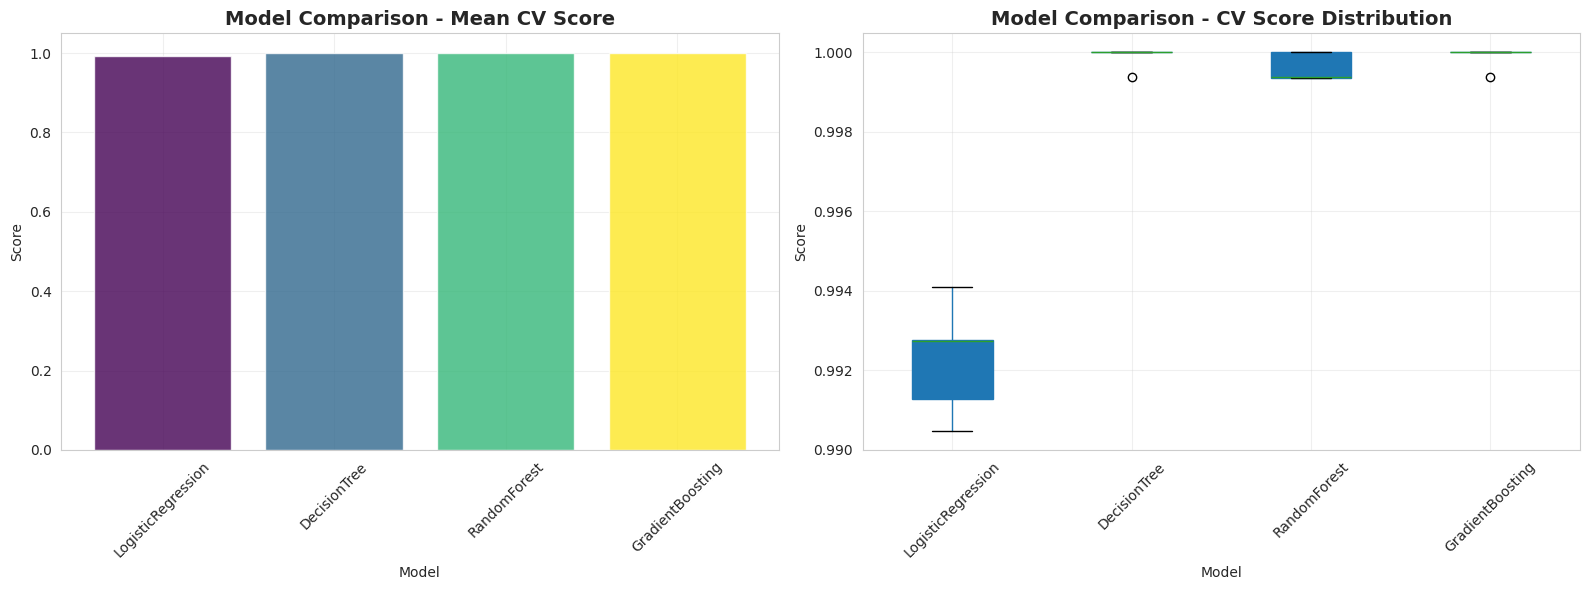


BEST MODEL: DecisionTree
Score: 0.9999


In [21]:
# ============================================================================
# 15. CROSS-VALIDATION AND MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

results = {}
cv_scores_all = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring=scoring_metric)

    if problem_type == "regression":
        cv_scores = -cv_scores  # Convert negative RMSE to positive
        results[name] = cv_scores.mean()
    else:
        results[name] = cv_scores.mean()

    cv_scores_all[name] = cv_scores

    print(f"{name}: Mean = {results[name]:.4f}, Std = {cv_scores.std():.4f}")
    print(f"  Scores: {cv_scores}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of mean scores
model_names = list(results.keys())
scores = list(results.values())
colors_map = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

axes[0].bar(model_names, scores, color=colors_map, alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score' if problem_type == "classification" else 'RMSE')
axes[0].set_title(f'Model Comparison - Mean CV Score', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Box plot of CV scores
cv_scores_df = pd.DataFrame(cv_scores_all)
cv_scores_df.boxplot(ax=axes[1], rot=45, patch_artist=True)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score' if problem_type == "classification" else 'RMSE')
axes[1].set_title(f'Model Comparison - CV Score Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best model
if problem_type == "regression":
    best_model_name = min(results, key=results.get)
else:
    best_model_name = max(results, key=results.get)

best_model = models[best_model_name]

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Score: {results[best_model_name]:.4f}")
print(f"{'='*80}")

In [22]:
# ============================================================================
# 16. FINAL MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print("TRAINING FINAL MODEL")
print("="*80)

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X_train, y_train)
print(f"\n{best_model_name} trained successfully on full training data.")


TRAINING FINAL MODEL

DecisionTree trained successfully on full training data.



FEATURE IMPORTANCE ANALYSIS

--- Top 20 Most Important Features ---
       Feature  Importance
5  total_score         1.0
0     q1_score         0.0
1     q2_score         0.0
2     q3_score         0.0
3     q4_score         0.0
4     q5_score         0.0


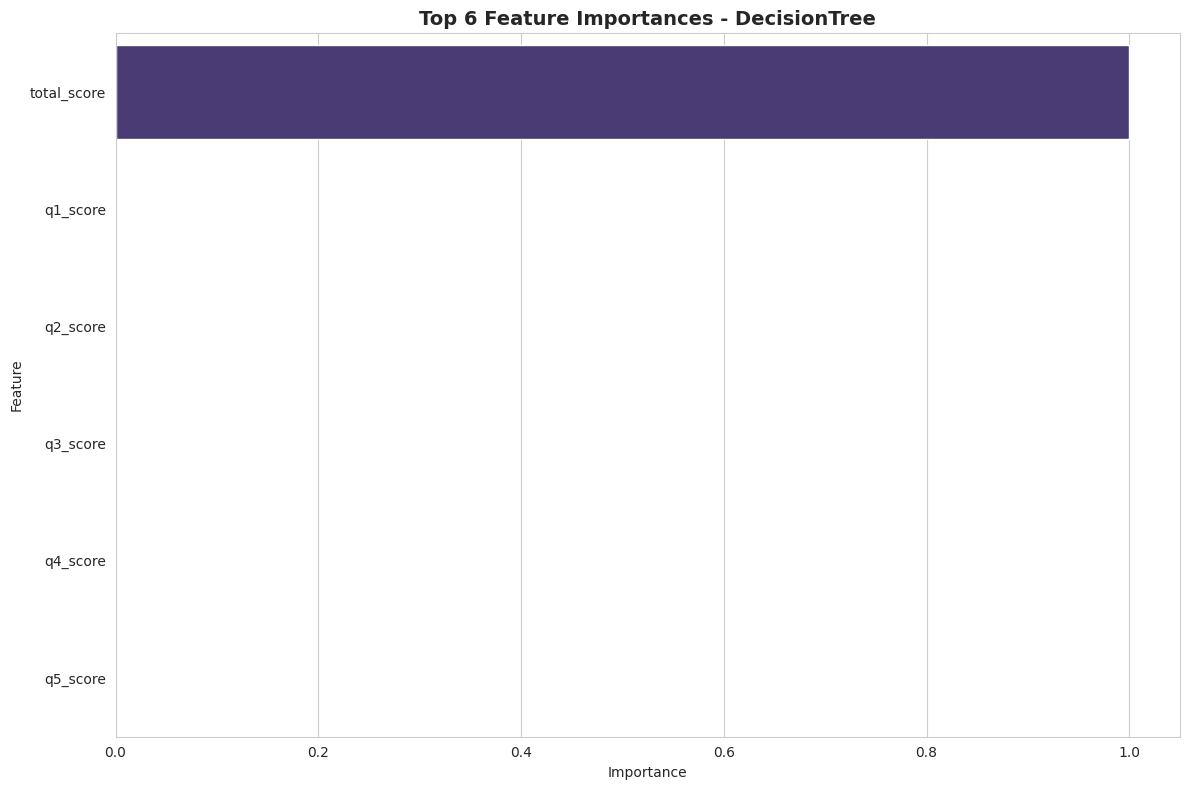

In [23]:
# ============================================================================
# 17. FEATURE IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

if hasattr(best_model, 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names_out = []

    # Numeric features
    feature_names_out.extend(numeric_features)

    # Categorical features (one-hot encoded)
    if len(categorical_features) > 0:
        categorical_pipeline_fitted = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']
        encoder = categorical_pipeline_fitted.named_steps['encoder']
        cat_feature_names = encoder.get_feature_names_out(categorical_features)
        feature_names_out.extend(cat_feature_names)

    importances = best_model.feature_importances_

    # Create DataFrame
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names_out[:len(importances)],
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\n--- Top 20 Most Important Features ---")
    print(feature_importances_df.head(20))

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(feature_importances_df))
    sns.barplot(x='Importance', y='Feature',
                data=feature_importances_df.head(top_n),
                palette='viridis')
    plt.title(f'Top {top_n} Feature Importances - {best_model_name}',
             fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()

elif hasattr(best_model, 'coef_'):
    # For linear models
    coefficients = best_model.coef_
    if len(coefficients.shape) > 1:
        coefficients = coefficients[0]

    feature_names_out = numeric_features.copy()

    coef_df = pd.DataFrame({
        'Feature': feature_names_out[:len(coefficients)],
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print("\n--- Model Coefficients ---")
    print(coef_df)

    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient'].head(20)]
    plt.barh(range(len(coef_df.head(20))), coef_df['Coefficient'].head(20),
            color=colors, alpha=0.7)
    plt.yticks(range(len(coef_df.head(20))), coef_df['Feature'].head(20))
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}',
             fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()


GENERATING LEARNING CURVES


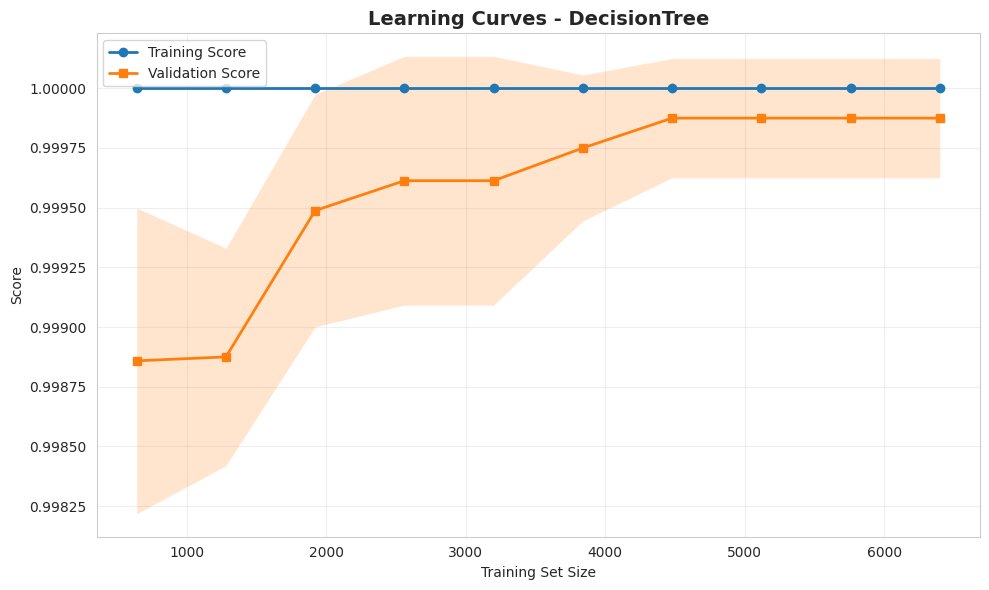

Learning curves generated successfully.


In [24]:
# ============================================================================
# 18. LEARNING CURVES
# ============================================================================
print("\n" + "="*80)
print("GENERATING LEARNING CURVES")
print("="*80)

train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline, X_train, y_train,
    cv=5, scoring=scoring_metric,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1, random_state=42
)

if problem_type == "regression":
    train_scores = -train_scores
    val_scores = -val_scores

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Score', marker='s', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Score' if problem_type == "classification" else 'RMSE')
plt.title(f'Learning Curves - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Learning curves generated successfully.")

In [32]:
# ============================================================================
# 19. PREDICTIONS ON TEST DATA
# ============================================================================
print("\n" + "="*80)
print("MAKING PREDICTIONS ON TEST DATA")
print("="*80)

# Add 'total_score' to X_test, which was present in X_train but not in the original test data.
# This is a common step if the target in training data is derived from features, and the test data needs the same derivation.
X_test['total_score'] = X_test[['q1_score', 'q2_score', 'q3_score', 'q4_score', 'q5_score']].sum(axis=1)

test_predictions = final_pipeline.predict(X_test)

print(f"\nFirst 10 predictions: {test_predictions[:10]}")
print(f"Prediction statistics (Count of each class):")
# For classification, we look at the count of each predicted class
from collections import Counter
prediction_counts = Counter(test_predictions)
for grade, count in prediction_counts.items():
    print(f"  {grade}: {count}")


MAKING PREDICTIONS ON TEST DATA

First 10 predictions: ['Fail' 'Fail' 'C' 'Fail' 'B' 'C' 'Fail' 'C' 'Fail' 'B']
Prediction statistics (Count of each class):
  Fail: 1021
  C: 559
  B: 402
  A: 18



COMPARING TRAIN VS TEST PREDICTIONS


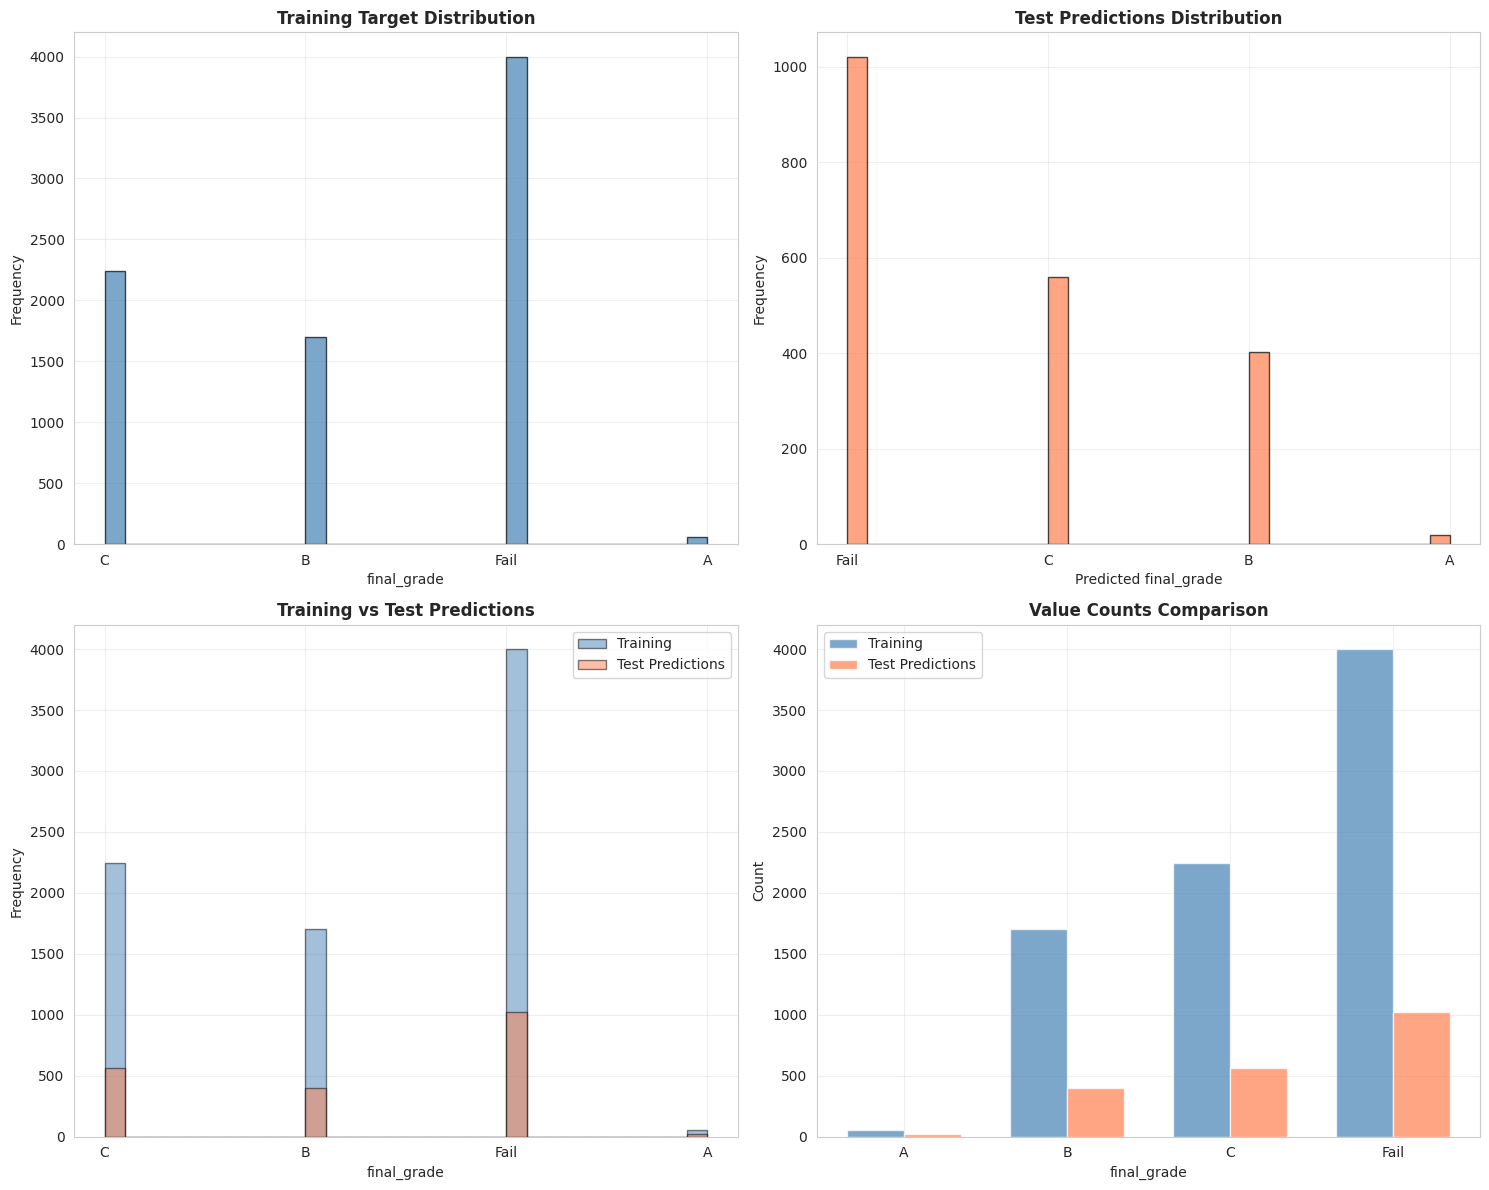


--- Value Counts for Training Target ---
final_grade
A         57
B       1703
C       2241
Fail    3999
Name: count, dtype: int64

--- Value Counts for Test Predictions ---
A         18
B        402
C        559
Fail    1021
Name: count, dtype: int64


In [33]:
# ============================================================================
# 20. PREDICTION DISTRIBUTION COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPARING TRAIN VS TEST PREDICTIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training target distribution
axes[0, 0].hist(y_train, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Training Target Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(target_col)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Test predictions distribution
axes[0, 1].hist(test_predictions, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Test Predictions Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(f'Predicted {target_col}')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Overlaid distributions
axes[1, 0].hist(y_train, bins=30, alpha=0.5, label='Training', color='steelblue', edgecolor='black')
axes[1, 0].hist(test_predictions, bins=30, alpha=0.5, label='Test Predictions', color='coral', edgecolor='black')
axes[1, 0].set_title('Training vs Test Predictions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel(target_col)
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Value counts comparison (for discrete targets)
if y_train.nunique() <= 20:
    train_counts = y_train.value_counts().sort_index()
    test_counts = pd.Series(test_predictions).value_counts().sort_index()

    x = np.arange(len(train_counts))
    width = 0.35

    axes[1, 1].bar(x - width/2, train_counts.values, width, label='Training',
                   color='steelblue', alpha=0.7)
    axes[1, 1].bar(x + width/2, test_counts.reindex(train_counts.index, fill_value=0).values,
                   width, label='Test Predictions', color='coral', alpha=0.7)
    axes[1, 1].set_xlabel(target_col)
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Value Counts Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(train_counts.index)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    # KDE plots for continuous targets
    sns.kdeplot(y_train, ax=axes[1, 1], label='Training', fill=True, alpha=0.5)
    sns.kdeplot(test_predictions, ax=axes[1, 1], label='Test Predictions', fill=True, alpha=0.5)
    axes[1, 1].set_title('Density Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel(target_col)
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print value counts
print('\n--- Value Counts for Training Target ---')
print(y_train.value_counts().sort_index())

print('\n--- Value Counts for Test Predictions ---')
print(pd.Series(test_predictions).value_counts().sort_index())


MODEL PERFORMANCE ANALYSIS ON TRAINING DATA

--- PREDICTION ANALYSIS FOR CLASSIFICATION ---

Prediction Confidence Statistics:
  Mean confidence (correct): 1.0000
  Mean confidence (incorrect): nan


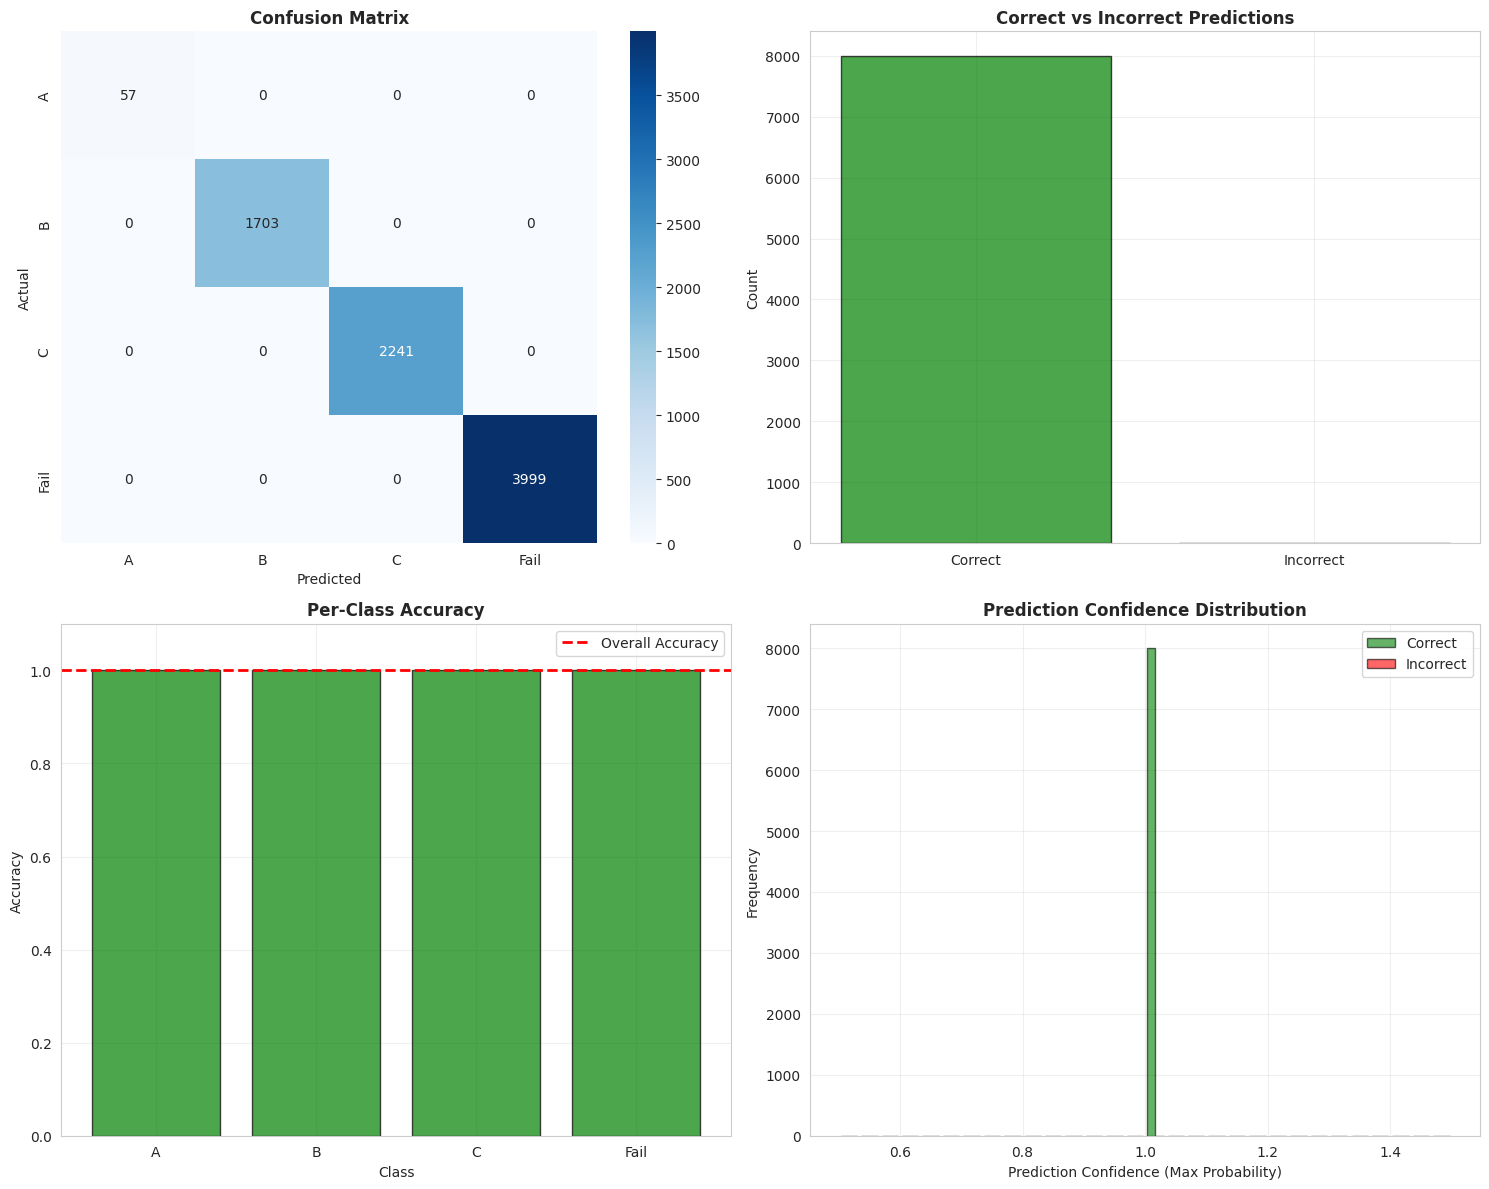


Training Set Performance Metrics:
  Accuracy: 1.0000
  F1 Score (Weighted): 1.0000
  F1 Score (Macro): 1.0000
  Correct Predictions: 8000/8000
  Incorrect Predictions: 0/8000

Per-Class Accuracy:
  Class A: 1.0000
  Class B: 1.0000
  Class C: 1.0000
  Class Fail: 1.0000


In [36]:
# ============================================================================
# 21. MODEL PERFORMANCE ANALYSIS ON TRAINING DATA
# ============================================================================
print("\n" + "="*80)
print("MODEL PERFORMANCE ANALYSIS ON TRAINING DATA")
print("="*80)

# Make predictions on training data
y_train_pred = final_pipeline.predict(X_train)

if problem_type == "regression":
    print("\n--- RESIDUAL ANALYSIS ---")

    residuals = y_train - y_train_pred

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Residuals vs Predicted
    axes[0, 0].scatter(y_train_pred, residuals, alpha=0.5, s=20, color='steelblue')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # Histogram of residuals
    axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # Q-Q plot of residuals
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot of Residuals', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # Actual vs Predicted
    axes[1, 1].scatter(y_train, y_train_pred, alpha=0.5, s=20, color='green')
    axes[1, 1].plot([y_train.min(), y_train.max()],
                    [y_train.min(), y_train.max()],
                    'r--', linewidth=2, label='Perfect Prediction')
    axes[1, 1].set_xlabel('Actual Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('Actual vs Predicted Values', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"\nTraining Set Performance Metrics:")
    print(f"  R² Score: {r2_score(y_train, y_train_pred):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"  MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
    print(f"  Mean Residual: {np.mean(residuals):.4f}")
    print(f"  Std of Residuals: {np.std(residuals):.4f}")

else:  # Classification
    print("\n--- PREDICTION ANALYSIS FOR CLASSIFICATION ---")

    # Create a more detailed analysis for classification
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    from sklearn.metrics import confusion_matrix, classification_report

    classes = sorted(y_train.unique())

    # Confusion Matrix (replaces Prediction vs Actual scatter with jitter)
    cm = confusion_matrix(y_train, y_train_pred, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=classes, yticklabels=classes)
    axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # Correct vs Incorrect Predictions (replaces Prediction error distribution)
    correct_mask = (y_train == y_train_pred)
    incorrect_mask = ~correct_mask
    correct_count = np.sum(correct_mask)
    incorrect_count = np.sum(incorrect_mask)

    axes[0, 1].bar(['Correct', 'Incorrect'], [correct_count, incorrect_count],
                   color=['green', 'red'], alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Correct vs Incorrect Predictions', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(True, alpha=0.3)

    # Class-wise accuracy
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    axes[1, 0].bar(range(len(classes)), class_accuracy, color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xticks(range(len(classes)))
    axes[1, 0].set_xticklabels(classes)
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylim([0, 1.1])
    axes[1, 0].axhline(y=accuracy_score(y_train, y_train_pred),
                      color='r', linestyle='--', linewidth=2, label='Overall Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Prediction confidence (if available)
    if hasattr(final_pipeline, 'predict_proba'):
        y_train_proba = final_pipeline.predict_proba(X_train)
        max_proba = np.max(y_train_proba, axis=1)

        # Separate correct and incorrect predictions
        correct_mask = y_train == y_train_pred

        axes[1, 1].hist([max_proba[correct_mask], max_proba[~correct_mask]],
                       bins=30, label=['Correct', 'Incorrect'],
                       color=['green', 'red'], alpha=0.6, edgecolor='black')
        axes[1, 1].set_xlabel('Prediction Confidence (Max Probability)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        print(f"\nPrediction Confidence Statistics:")
        print(f"  Mean confidence (correct): {np.mean(max_proba[correct_mask]):.4f}")
        print(f"  Mean confidence (incorrect): {np.mean(max_proba[~correct_mask]):.4f}")
    else:
        axes[1, 1].text(0.5, 0.5, 'Probability predictions\nnot available for this model',
                       ha='center', va='center', fontsize=14)
        axes[1, 1].set_xlim([0, 1])
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print metrics
    print(f"\nTraining Set Performance Metrics:")
    print(f"  Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"  F1 Score (Weighted): {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"  F1 Score (Macro): {f1_score(y_train, y_train_pred, average='macro'):.4f}")

    # Additional error analysis
    correct_predictions = np.sum(y_train == y_train_pred)
    total_predictions = len(y_train)
    print(f"  Correct Predictions: {correct_predictions}/{total_predictions}")
    print(f"  Incorrect Predictions: {total_predictions - correct_predictions}/{total_predictions}")

    print(f"\nPer-Class Accuracy:")
    for i, cls in enumerate(classes):
        print(f"  Class {cls}: {class_accuracy[i]:.4f}")


DETAILED CONFUSION MATRIX AND CLASSIFICATION METRICS


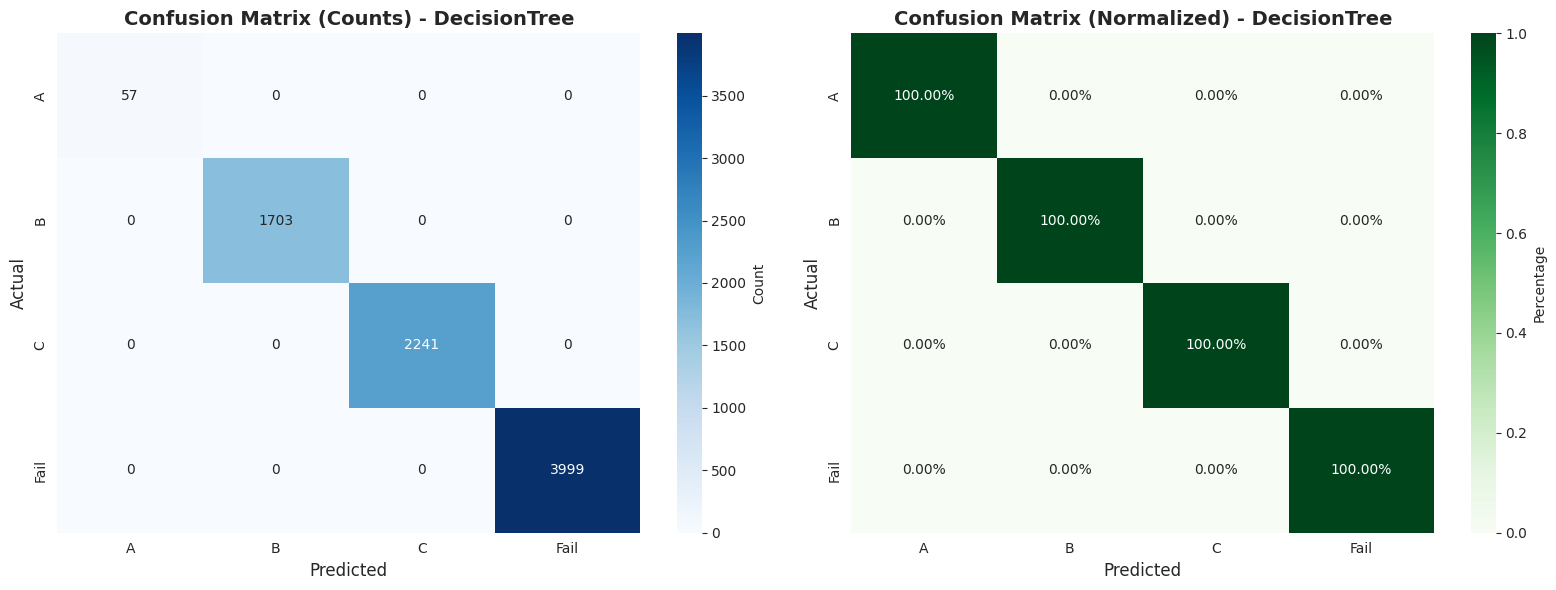


--- Classification Report (Training Data) ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        57
           B       1.00      1.00      1.00      1703
           C       1.00      1.00      1.00      2241
        Fail       1.00      1.00      1.00      3999

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



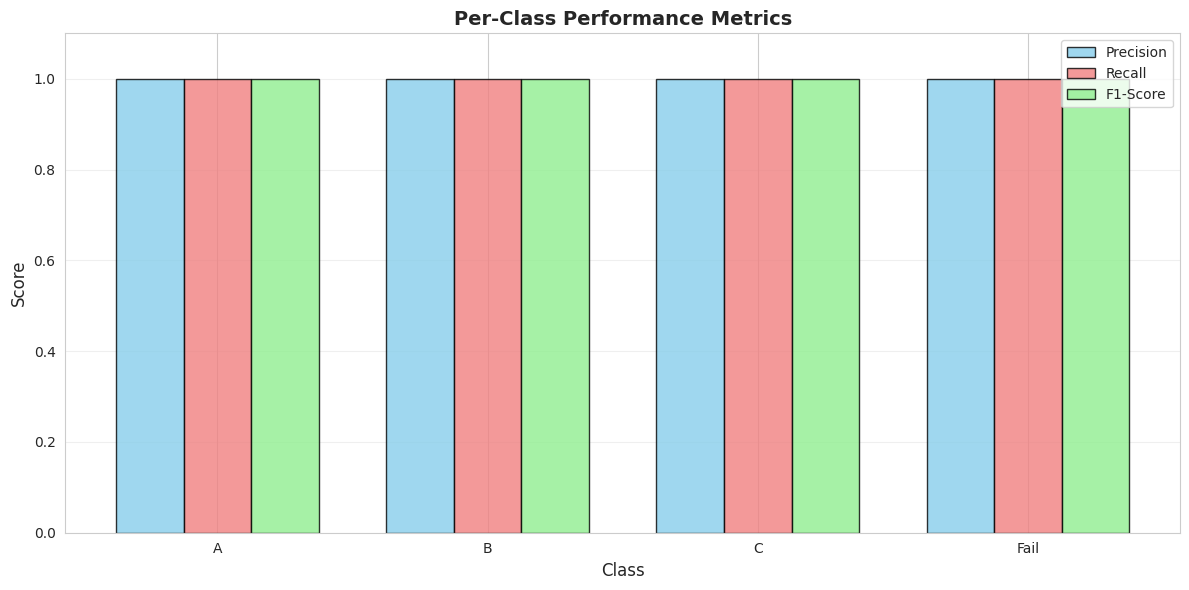


--- Summary Metrics ---
Overall Accuracy: 1.0000
Macro Average Precision: 1.0000
Macro Average Recall: 1.0000
Macro Average F1-Score: 1.0000
Weighted Average F1-Score: 1.0000


In [37]:
# ============================================================================
# 22. DETAILED CONFUSION MATRIX AND CLASSIFICATION REPORT
# ============================================================================
if problem_type == "classification":
    print("\n" + "="*80)
    print("DETAILED CONFUSION MATRIX AND CLASSIFICATION METRICS")
    print("="*80)

    # Confusion Matrix
    cm = confusion_matrix(y_train, y_train_pred)
    classes = sorted(y_train.unique())

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Raw counts confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes,
                ax=axes[0],
                cbar_kws={'label': 'Count'})
    axes[0].set_title(f'Confusion Matrix (Counts) - {best_model_name}',
                     fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Actual', fontsize=12)
    axes[0].set_xlabel('Predicted', fontsize=12)

    # Normalized confusion matrix (percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=classes,
                yticklabels=classes,
                ax=axes[1],
                cbar_kws={'label': 'Percentage'})
    axes[1].set_title(f'Confusion Matrix (Normalized) - {best_model_name}',
                     fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Actual', fontsize=12)
    axes[1].set_xlabel('Predicted', fontsize=12)

    plt.tight_layout()
    plt.savefig('confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Classification Report
    print("\n--- Classification Report (Training Data) ---")
    print(classification_report(y_train, y_train_pred))

    # Per-class metrics visualization
    from sklearn.metrics import precision_score, recall_score, f1_score

    precision_per_class = precision_score(y_train, y_train_pred, average=None)
    recall_per_class = recall_score(y_train, y_train_pred, average=None)
    f1_per_class = f1_score(y_train, y_train_pred, average=None)

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(classes))
    width = 0.25

    ax.bar(x - width, precision_per_class, width, label='Precision',
           color='skyblue', alpha=0.8, edgecolor='black')
    ax.bar(x, recall_per_class, width, label='Recall',
           color='lightcoral', alpha=0.8, edgecolor='black')
    ax.bar(x + width, f1_per_class, width, label='F1-Score',
           color='lightgreen', alpha=0.8, edgecolor='black')

    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])

    plt.tight_layout()
    plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n--- Summary Metrics ---")
    print(f"Overall Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Macro Average Precision: {precision_score(y_train, y_train_pred, average='macro'):.4f}")
    print(f"Macro Average Recall: {recall_score(y_train, y_train_pred, average='macro'):.4f}")
    print(f"Macro Average F1-Score: {f1_score(y_train, y_train_pred, average='macro'):.4f}")
    print(f"Weighted Average F1-Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

In [38]:
# ============================================================================
# 23. SAVE OUTPUTS
# ============================================================================
print("\n" + "="*80)
print("SAVING OUTPUTS")
print("="*80)

# Save submission
submission = pd.DataFrame({
    "prediction": test_predictions
})
submission.to_csv("submission.csv", index=False)
print("\nSubmission file saved: submission.csv")

# Save model
joblib.dump(final_pipeline, "final_model.pkl")
print("Model saved: final_model.pkl")

# Save detailed predictions
detailed_predictions = X_test.copy()
detailed_predictions['prediction'] = test_predictions
detailed_predictions.to_csv("detailed_predictions.csv", index=False)
print("Detailed predictions saved: detailed_predictions.csv")

# Save model performance summary
performance_summary = {
    'Problem Type': problem_type,
    'Best Model': best_model_name,
    'CV Score': results[best_model_name],
    'Number of Features': len(numeric_features) + len(categorical_features),
    'Numeric Features': len(numeric_features),
    'Categorical Features': len(categorical_features),
    'Training Samples': len(X_train),
    'Test Samples': len(X_test)
}

with open('model_summary.txt', 'w') as f:
    f.write("MODEL PERFORMANCE SUMMARY\n")
    f.write("="*80 + "\n\n")
    for key, value in performance_summary.items():
        f.write(f"{key}: {value}\n")
    f.write("\n" + "="*80 + "\n")
    f.write("MODEL COMPARISON RESULTS\n")
    f.write("="*80 + "\n\n")
    for model_name, score in sorted(results.items(),
                                    key=lambda x: x[1],
                                    reverse=(problem_type=="classification")):
        f.write(f"{model_name}: {score:.4f}\n")

print("Model summary saved: model_summary.txt")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated Files:")
print("  - submission.csv")
print("  - final_model.pkl")
print("  - detailed_predictions.csv")
print("  - model_summary.txt")
print("\nGenerated Visualizations:")
print("  1. target_analysis.png - Target variable distribution analysis")
print("  2. missing_values.png - Missing value heatmaps")
print("  3. missing_percentage.png - Missing value percentages (if applicable)")
print("  4. numeric_features_distribution.png - Distribution and outlier analysis")
print("  5. pairplot.png - Pairwise feature relationships (if applicable)")
print("  6. categorical_*.png - Categorical feature distributions (if applicable)")
print("  7. correlation_heatmap.png - Feature correlation matrix")
print("  8. target_correlation.png - Feature correlation with target")
print("  9. feature_vs_target.png - Scatter/box plots of features vs target")
print("  10. violin_plots.png - Violin plots for classification (if applicable)")
print("  11. model_comparison.png - Model performance comparison")
print("  12. feature_importances.png - Feature importance ranking (if applicable)")
print("  13. feature_coefficients.png - Model coefficients (if applicable)")
print("  14. learning_curves.png - Learning curves analysis")
print("  15. prediction_distribution.png - Train vs test prediction comparison")
if problem_type == "regression":
    print("  16. residual_analysis.png - Residual analysis plots")
else:
    print("  16. prediction_analysis.png - Prediction analysis for classification")
    print("  17. confusion_matrix_detailed.png - Detailed confusion matrices")
    print("  18. per_class_metrics.png - Per-class performance metrics")

print(f"\nTotal visualizations generated: 15-18 plots")
print("\nAll analysis complete! Check the generated files for detailed insights.")


SAVING OUTPUTS

Submission file saved: submission.csv
Model saved: final_model.pkl
Detailed predictions saved: detailed_predictions.csv
Model summary saved: model_summary.txt

ANALYSIS COMPLETE!

Generated Files:
  - submission.csv
  - final_model.pkl
  - detailed_predictions.csv
  - model_summary.txt

Generated Visualizations:
  1. target_analysis.png - Target variable distribution analysis
  2. missing_values.png - Missing value heatmaps
  3. missing_percentage.png - Missing value percentages (if applicable)
  4. numeric_features_distribution.png - Distribution and outlier analysis
  5. pairplot.png - Pairwise feature relationships (if applicable)
  6. categorical_*.png - Categorical feature distributions (if applicable)
  7. correlation_heatmap.png - Feature correlation matrix
  8. target_correlation.png - Feature correlation with target
  9. feature_vs_target.png - Scatter/box plots of features vs target
  10. violin_plots.png - Violin plots for classification (if applicable)
  11